In [6]:
!pip install datasets

In [7]:
import pandas as pd
import numpy as np
import json
import os
import re

import matplotlib.pyplot as plt

from huggingface_hub import notebook_login
from datasets import Dataset, load_dataset

In [8]:
hparams = {
    'train_split': '/content/drive/My Drive/Uni/Máster/TFM/tfm_audio_embeddings_chatbot/data/dstc2_train.flist',
    'dev_split': '/content/drive/My Drive/Uni/Máster/TFM/tfm_audio_embeddings_chatbot/data/dstc2_dev.flist',
    'test_split': '/content/drive/My Drive/Uni/Máster/TFM/tfm_audio_embeddings_chatbot/data/dstc2_test.flist',
}

In [9]:
notebook_login()

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) Load data

### 1.1) Load text dataset



In [11]:
dataset = load_dataset('danielroncel/dstc2_dialogues_processed')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/22266 [00:00<?, ? examples/s]

In [12]:
df = dataset['train'].to_pandas()
df.head()

,session_id,turn_index,audio_file,transcript,chat_history_last_9,chat_history_last_9_tokenized,speaker_text_last_9_tokenized,attention_mask,label_semantics,label
0,voip-00d76b791d-20130327_010416,2,pt344x_0000993_0001219.wav,<user>expensive restaurant in the south part o...,"<sys>Hello , welcome to the Cambridge restaura...","[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|area_inform|pricerange,request|food
1,voip-00d76b791d-20130327_010416,4,pt344x_0001649_0001680.wav,<user>any<API_call><DB_result>,"<sys>Hello , welcome to the Cambridge restaura...","[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|this,inform|area_inform|food_inform|pricerange_offe...
2,voip-00d76b791d-20130327_010416,6,pt344x_0002674_0002736.wav,<user>address<API_call><DB_result>,"<sys>Hello , welcome to the Cambridge restaura...","[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",request|addr,inform|addr_offer|name
3,voip-00d76b791d-20130327_010416,8,pt344x_0003533_0003611.wav,<user>type of food<API_call><DB_result>,"<sys>Hello , welcome to the Cambridge restaura...","[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",request|food,inform|area_inform|pricerange_offer|name
4,voip-00d76b791d-20130327_011116,2,pt344x_0001082_0001294.wav,<user>lebanese restaurant in the west part of ...,"<sys>Hello , welcome to the Cambridge restaura...","[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|area_inform|food,request|food


In [13]:
cond = df['label'].str.contains('impl-conf')
df[cond]['chat_history_last_9'].sample().iloc[0]

"<sys>Hello , welcome to the Cambridge restaurant system? You can ask for restaurants by area , price range or food type . How may I help you?<user>find cheap restaurant<sys>There are 22 restaurants in the cheap price range . What type of food do you want?<user>christmas food<API_call><no_DB_result><sys>I'm sorry but there is no restaurant serving christmas food<user>asian oriental food<sys>Could you please repeat that?<user>asian oriental food"

In [14]:
(df['audio_file'].isna() | df['audio_file'] == '').sum()

0

### 1.2) Load audio dataset

In [15]:
dataset = load_dataset('danielroncel/dstc2_audios')
dataset

Generating train split:   0%|          | 0/25516 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'session_ids'],
        num_rows: 25516
    })
})

In [16]:
dataset['train'][0]['audio']

{'path': 'pt344x_0000993_0001219.wav',
 'array': array([ 0.00033569,  0.00033569,  0.00012207, ..., -0.00067139,
        -0.00021362,  0.00054932]),
 'sampling_rate': 16000}

In [17]:
df_audios = dataset['train'].to_pandas()
df_audios.head()

,audio,session_ids
0,{'bytes': b'RIFF\xa4\x1a\x01\x00WAVEfmt \x10\x...,voip-00d76b791d-20130327_010416
1,{'bytes': b'RIFF\xe4&\x00\x00WAVEfmt \x10\x00\...,voip-00d76b791d-20130327_010416
2,{'bytes': b'RIFF\xa4M\x00\x00WAVEfmt \x10\x00\...,voip-00d76b791d-20130327_010416
3,{'bytes': b'RIFF\xa4a\x00\x00WAVEfmt \x10\x00\...,voip-00d76b791d-20130327_010416
4,{'bytes': b'RIFF\xa4a\x00\x00WAVEfmt \x10\x00\...,voip-00d76b791d-20130327_010416


In [18]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    paths = [x["path"] for x in examples["audio"]]
    sampling_rate = [x["sampling_rate"] for x in examples["audio"]]

    return {'path': paths, 'array': audio_arrays, 'sampling_rate': sampling_rate}

dataset = dataset.map(preprocess_function, batched=True)
dataset

Map:   0%|          | 0/25516 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'session_ids', 'path', 'array', 'sampling_rate'],
        num_rows: 25516
    })
})

In [19]:
dataset = dataset.remove_columns(["audio"])
dataset

DatasetDict({
    train: Dataset({
        features: ['session_ids', 'path', 'array', 'sampling_rate'],
        num_rows: 25516
    })
})

In [20]:
df_audios = dataset['train'].to_pandas()
df_audios.head()

,session_ids,path,array,sampling_rate
0,voip-00d76b791d-20130327_010416,pt344x_0000993_0001219.wav,"[0.000335693359375, 0.000335693359375, 0.00012...",16000
1,voip-00d76b791d-20130327_010416,pt344x_0001649_0001680.wav,"[0.0001220703125, 0.000152587890625, 0.0003356...",16000
2,voip-00d76b791d-20130327_010416,pt344x_0002674_0002736.wav,"[0.000152587890625, 0.000152587890625, 0.00027...",16000
3,voip-00d76b791d-20130327_010416,pt344x_0003533_0003611.wav,"[0.000213623046875, 0.00054931640625, 0.000671...",16000
4,voip-00d76b791d-20130327_010416,pt344x_0004453_0004531.wav,"[0.000213623046875, 0.000335693359375, 0.00027...",16000


### 1.2) Load partitions

In [21]:
# load train session ids
with open(hparams['train_split'], 'r') as file:
  lines = file.readlines()

  train_session_ids = list()
  for line in lines:
    line = line.strip()

    session_id = re.search(r'Mar\d{2}_S\dA\d\/(.*)', line).group(1)
    train_session_ids.append(session_id)

In [22]:
# load dev session ids
with open(hparams['dev_split'], 'r') as file:
  lines = file.readlines()

  dev_session_ids = list()
  for line in lines:
    line = line.strip()

    session_id = re.search(r'Mar\d{2}_S\dA\d\/(.*)', line).group(1)
    dev_session_ids.append(session_id)

In [23]:
# load test session ids
with open(hparams['test_split'], 'r') as file:
  lines = file.readlines()

  test_session_ids = list()
  for line in lines:
    line = line.strip()

    session_id = re.search(r'Mar\d{2}_S\dA\d\/(.*)', line).group(1)
    test_session_ids.append(session_id)

In [24]:
len(train_session_ids), len(dev_session_ids), len(test_session_ids), len(train_session_ids) + len(dev_session_ids) + len(test_session_ids)

(1612, 506, 1117, 3235)

## 2) Study the dataset as a whole

In [25]:
n_rows = len(df)
print(f"{n_rows} rows")

22266 rows


In [26]:
n_nan_label = (df['label'].isna() | (df['label'] == '')).sum()
print(f"{n_nan_label} rows without labels")

0 rows without labels


In [27]:
n_labels = df['label'].nunique()
print(f"{n_labels} labels")

60 labels


### 2.1) Label frequency

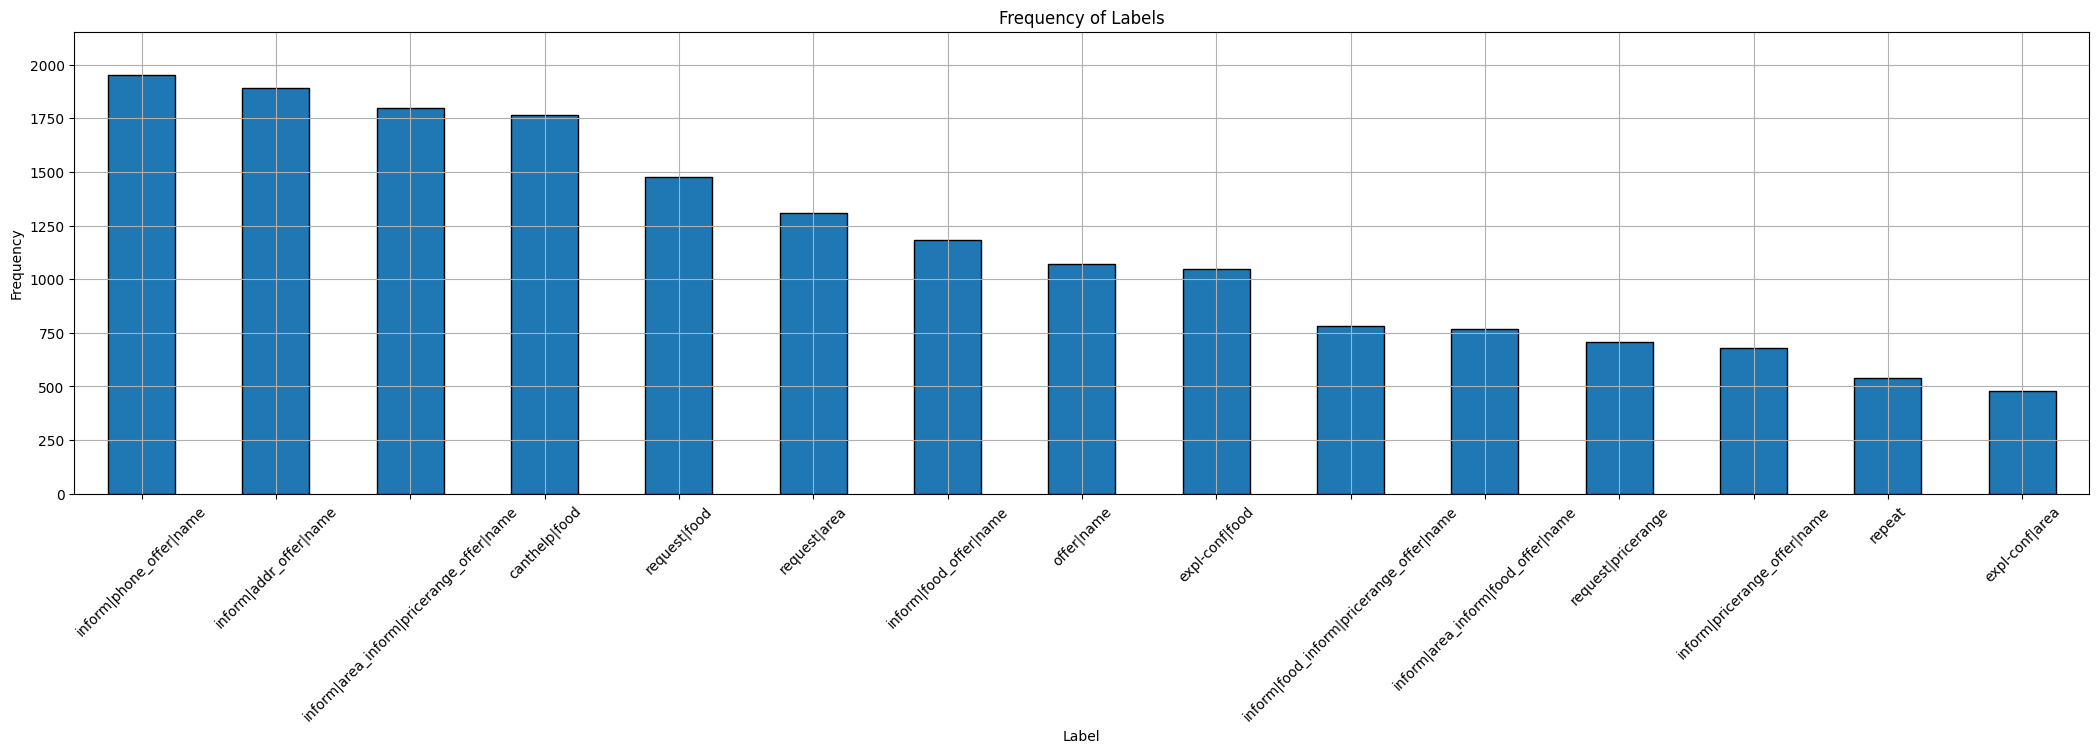

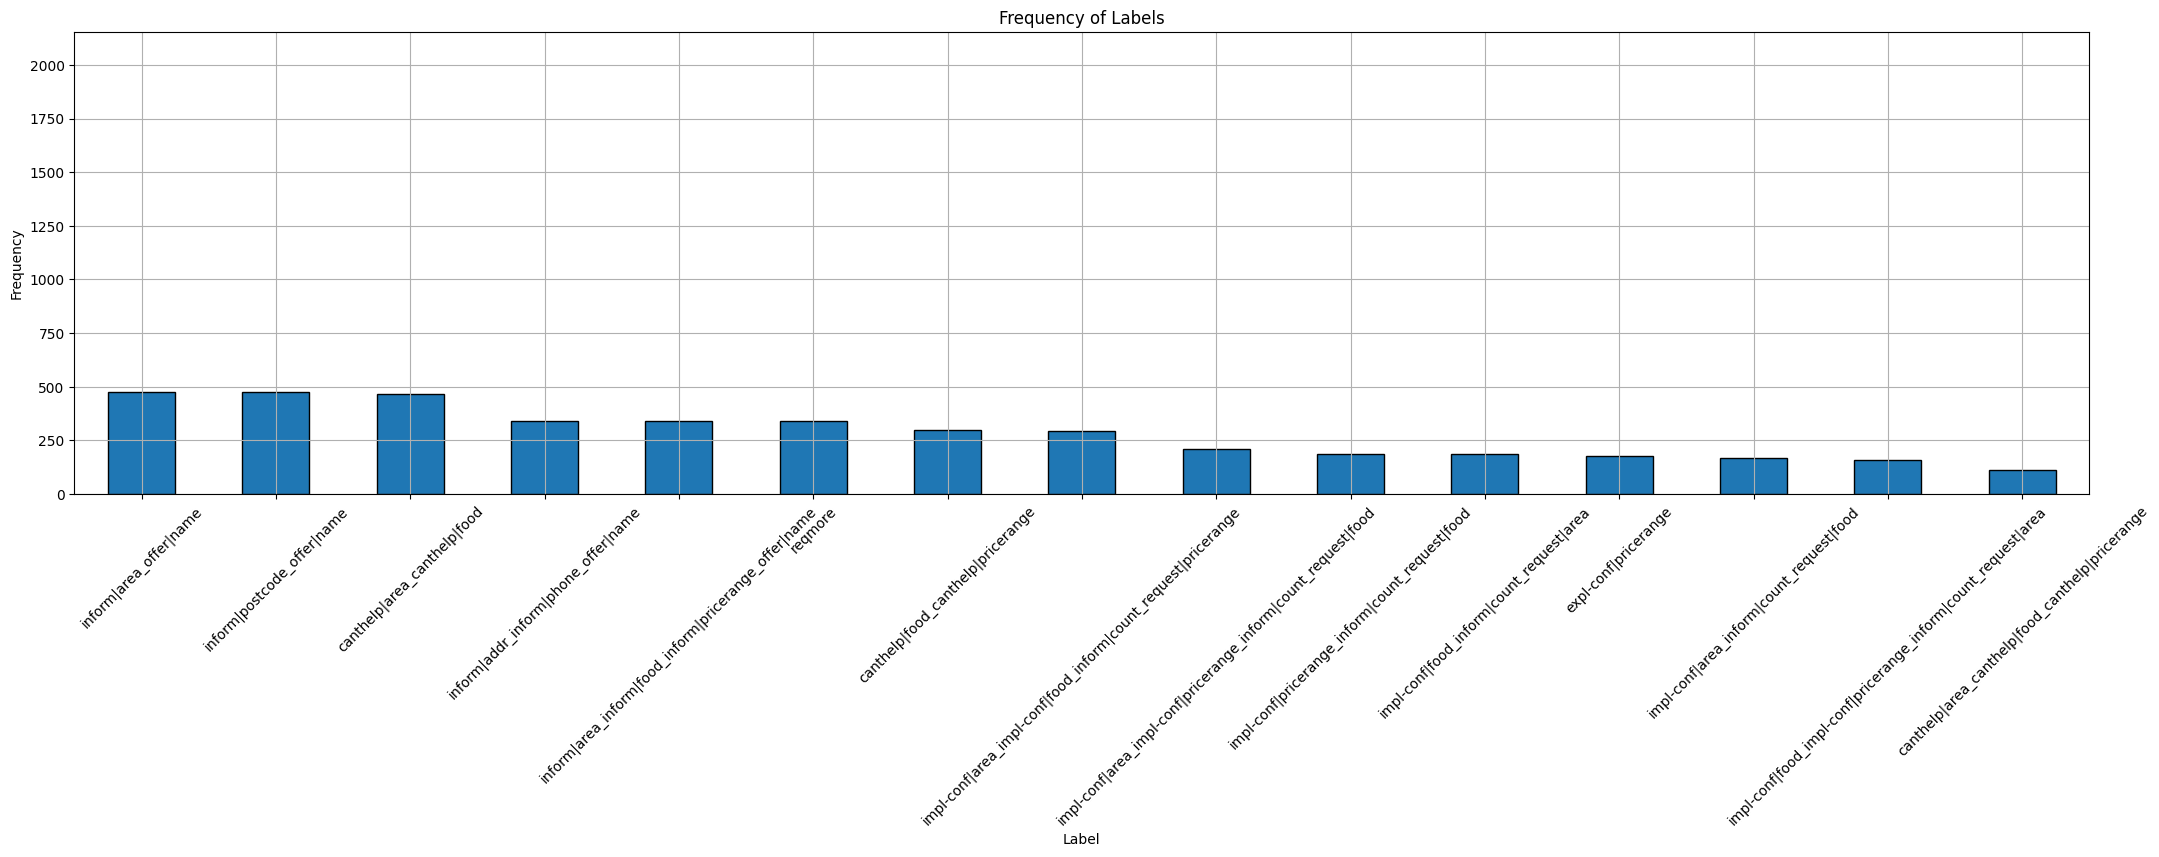

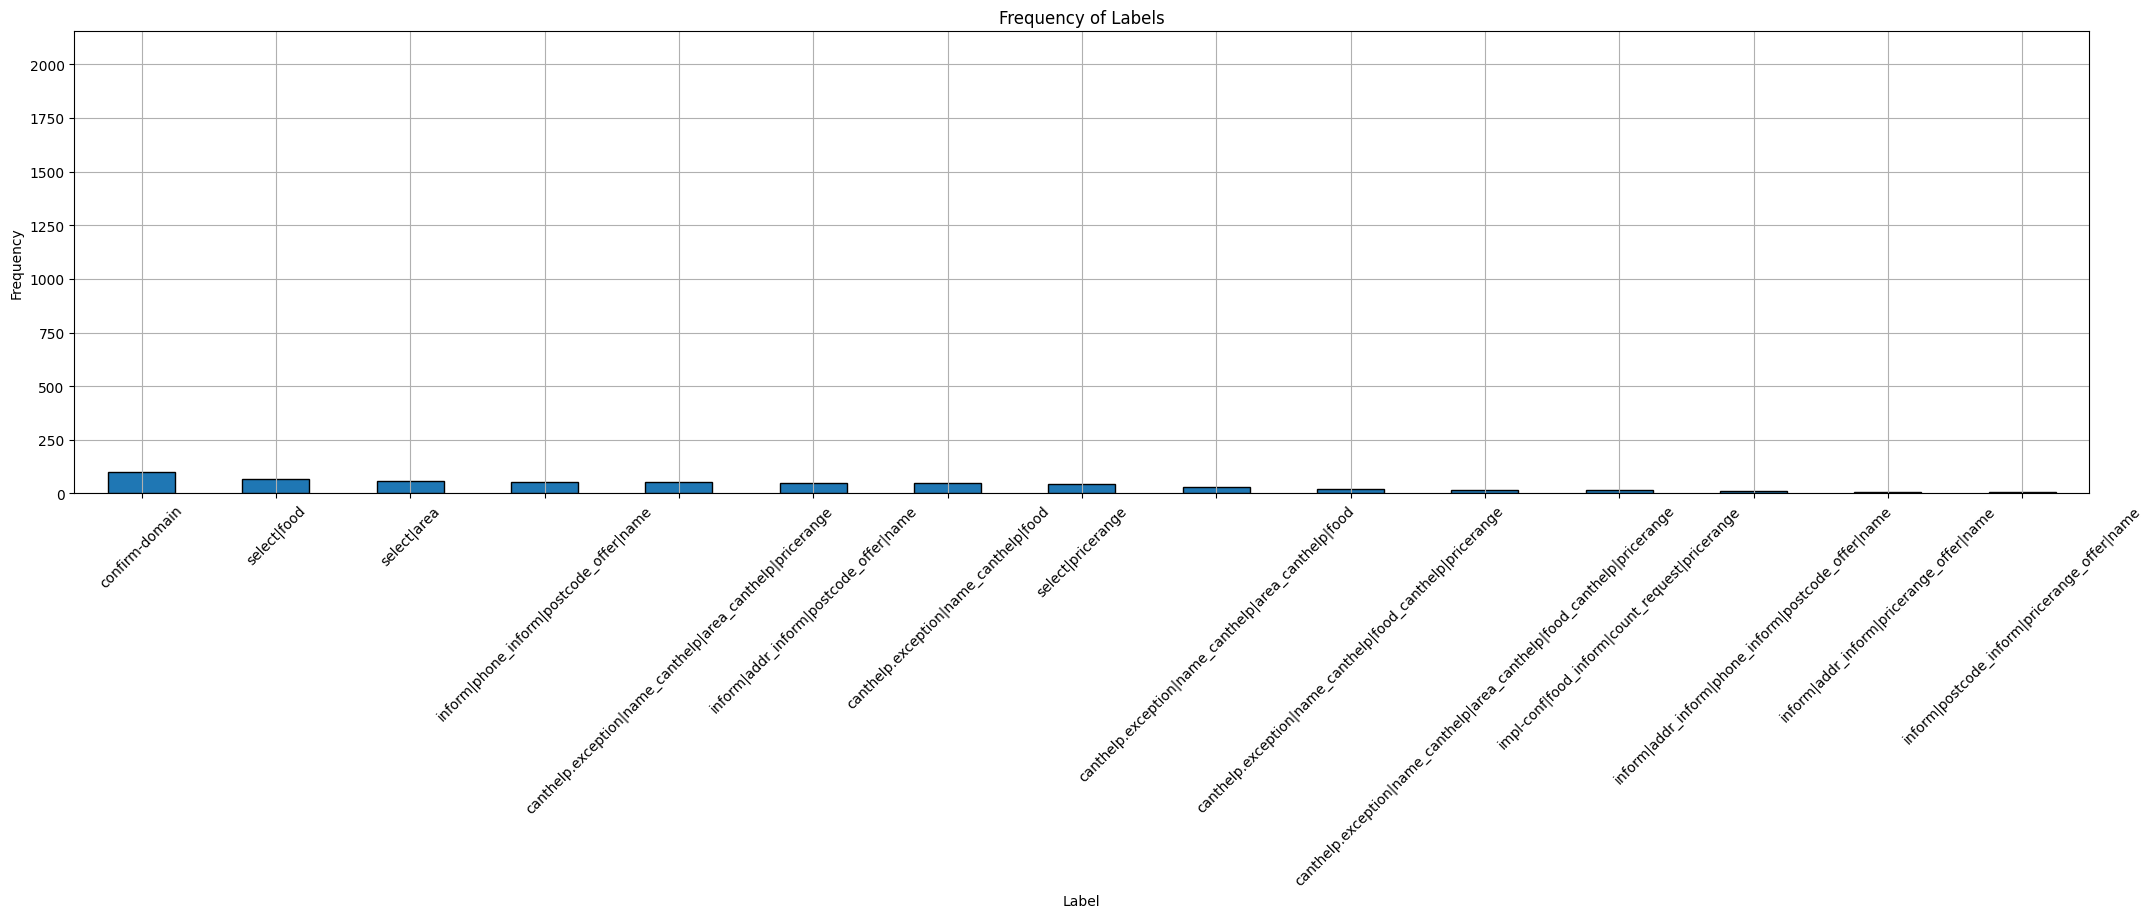

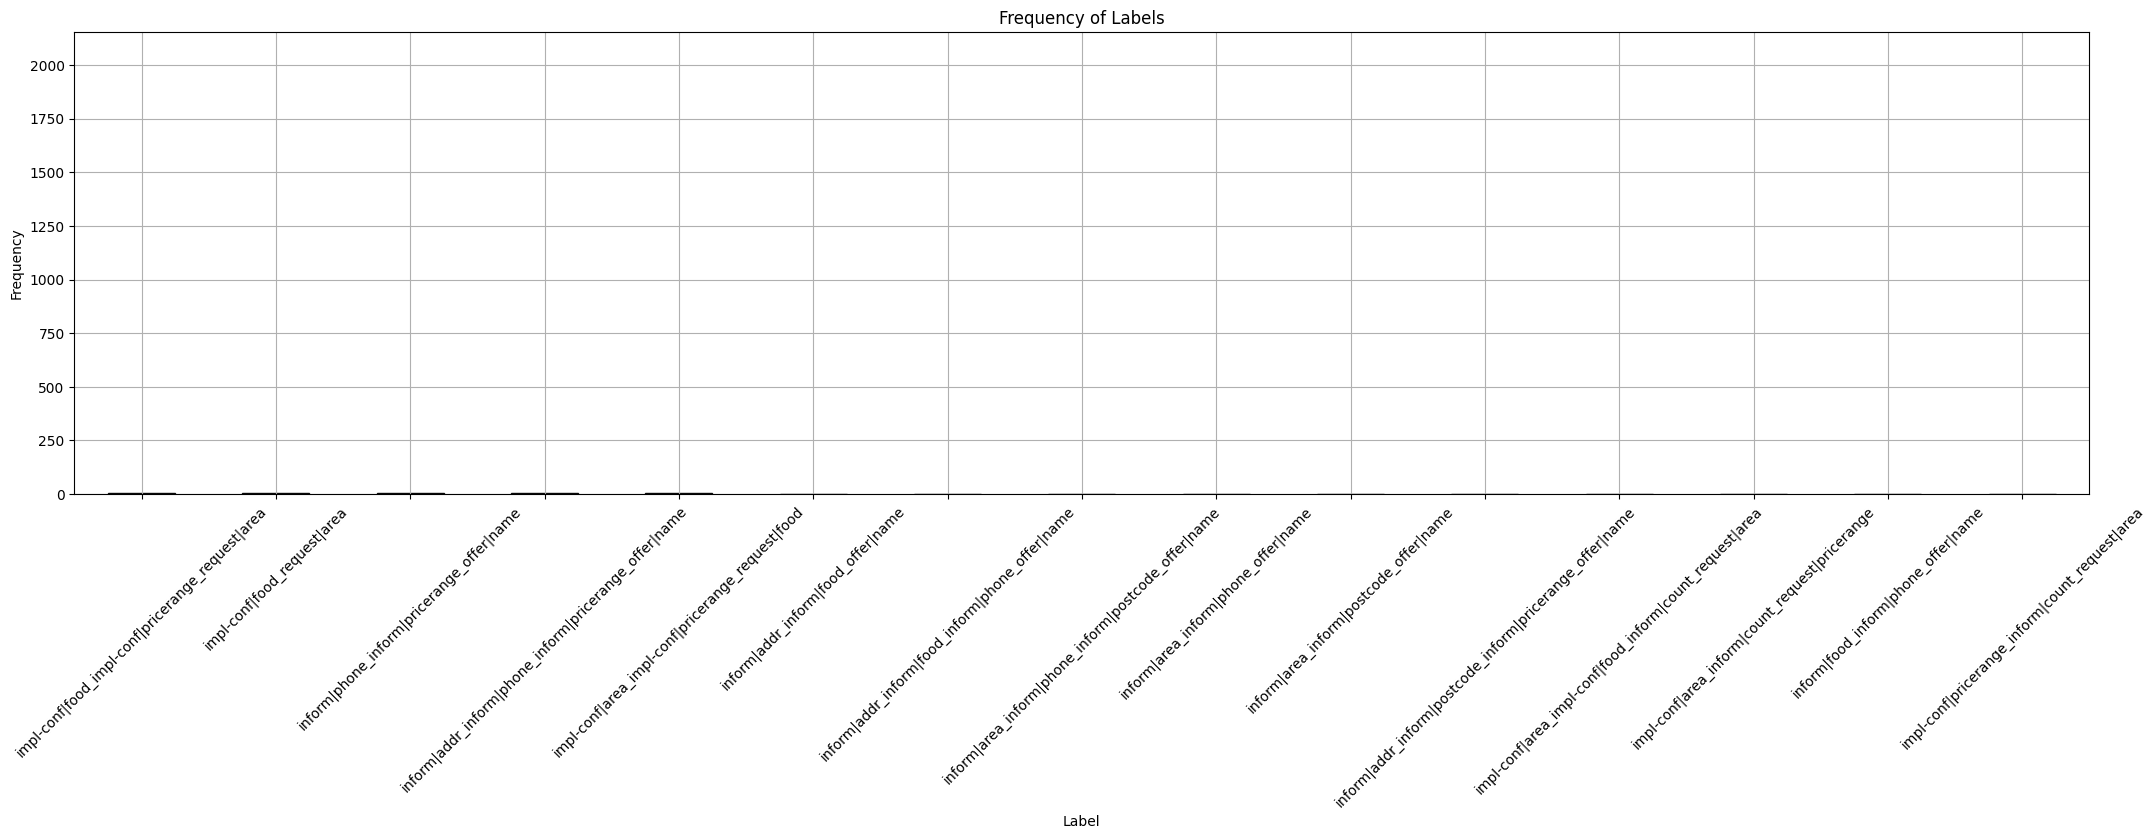

In [28]:
# Get frequency of each label and sort them
label_counts = df['label'].value_counts().sort_values()[::-1]

num_iterations = (len(label_counts) // 16) + 1

for i in range(num_iterations):
  # Create a new figure for each iteration
  plt.figure(figsize=(26, 6))

  # Extract subset of data for this iteration
  subset_label_counts = label_counts[15*i:15*(i+1)]

  # Create bar plot for this subset
  subset_label_counts.plot(kind='bar', edgecolor='black')

  plt.title('Frequency of Labels')
  plt.xlabel('Label')
  plt.ylim(0, label_counts.max() + 200)
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)
  plt.grid()
  plt.show()

### 2.2) Cumulative label frequency

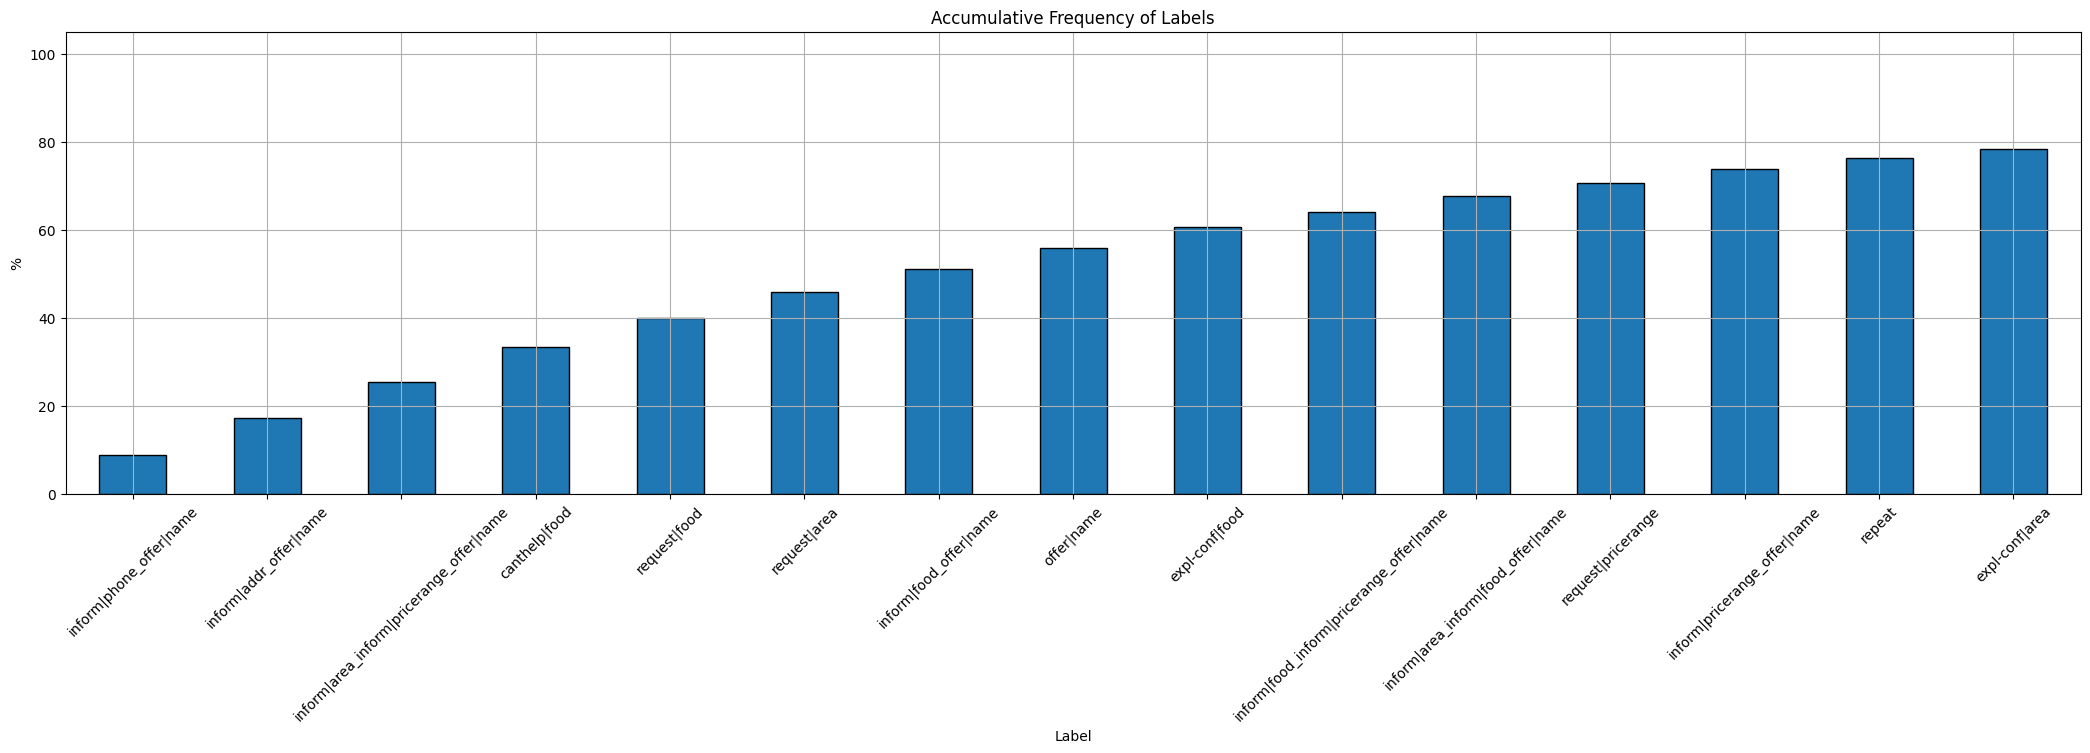

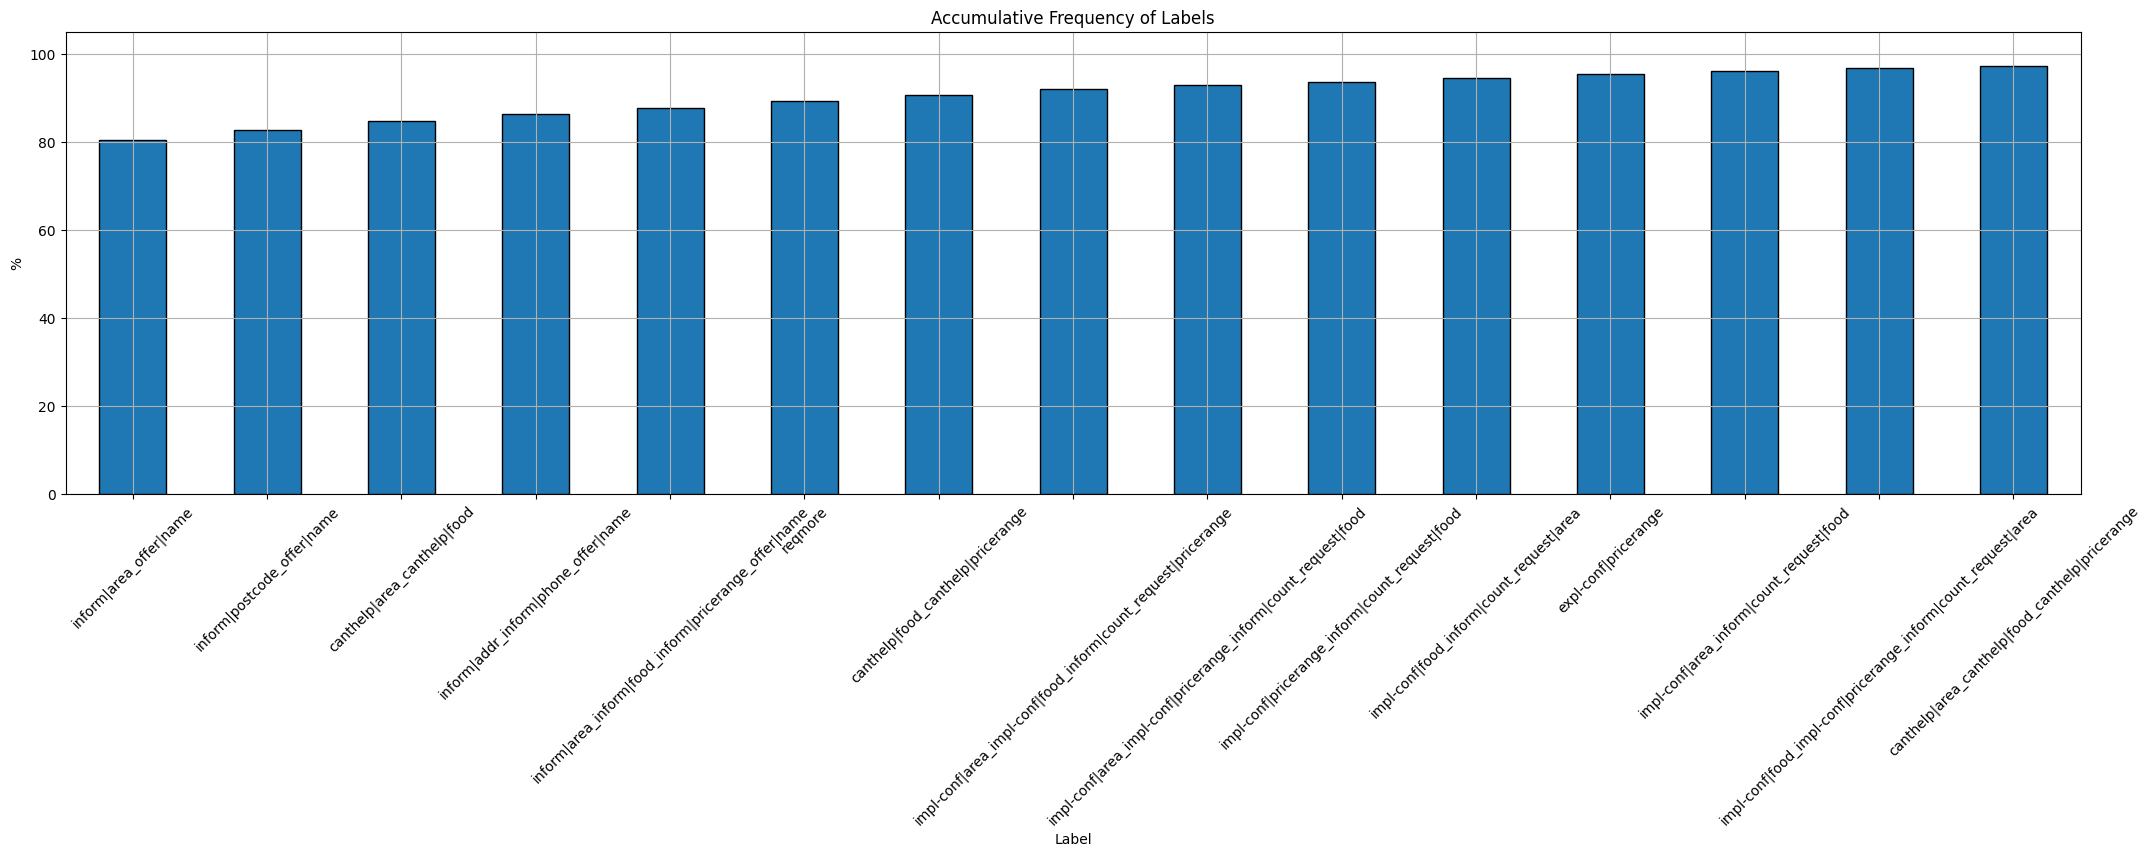

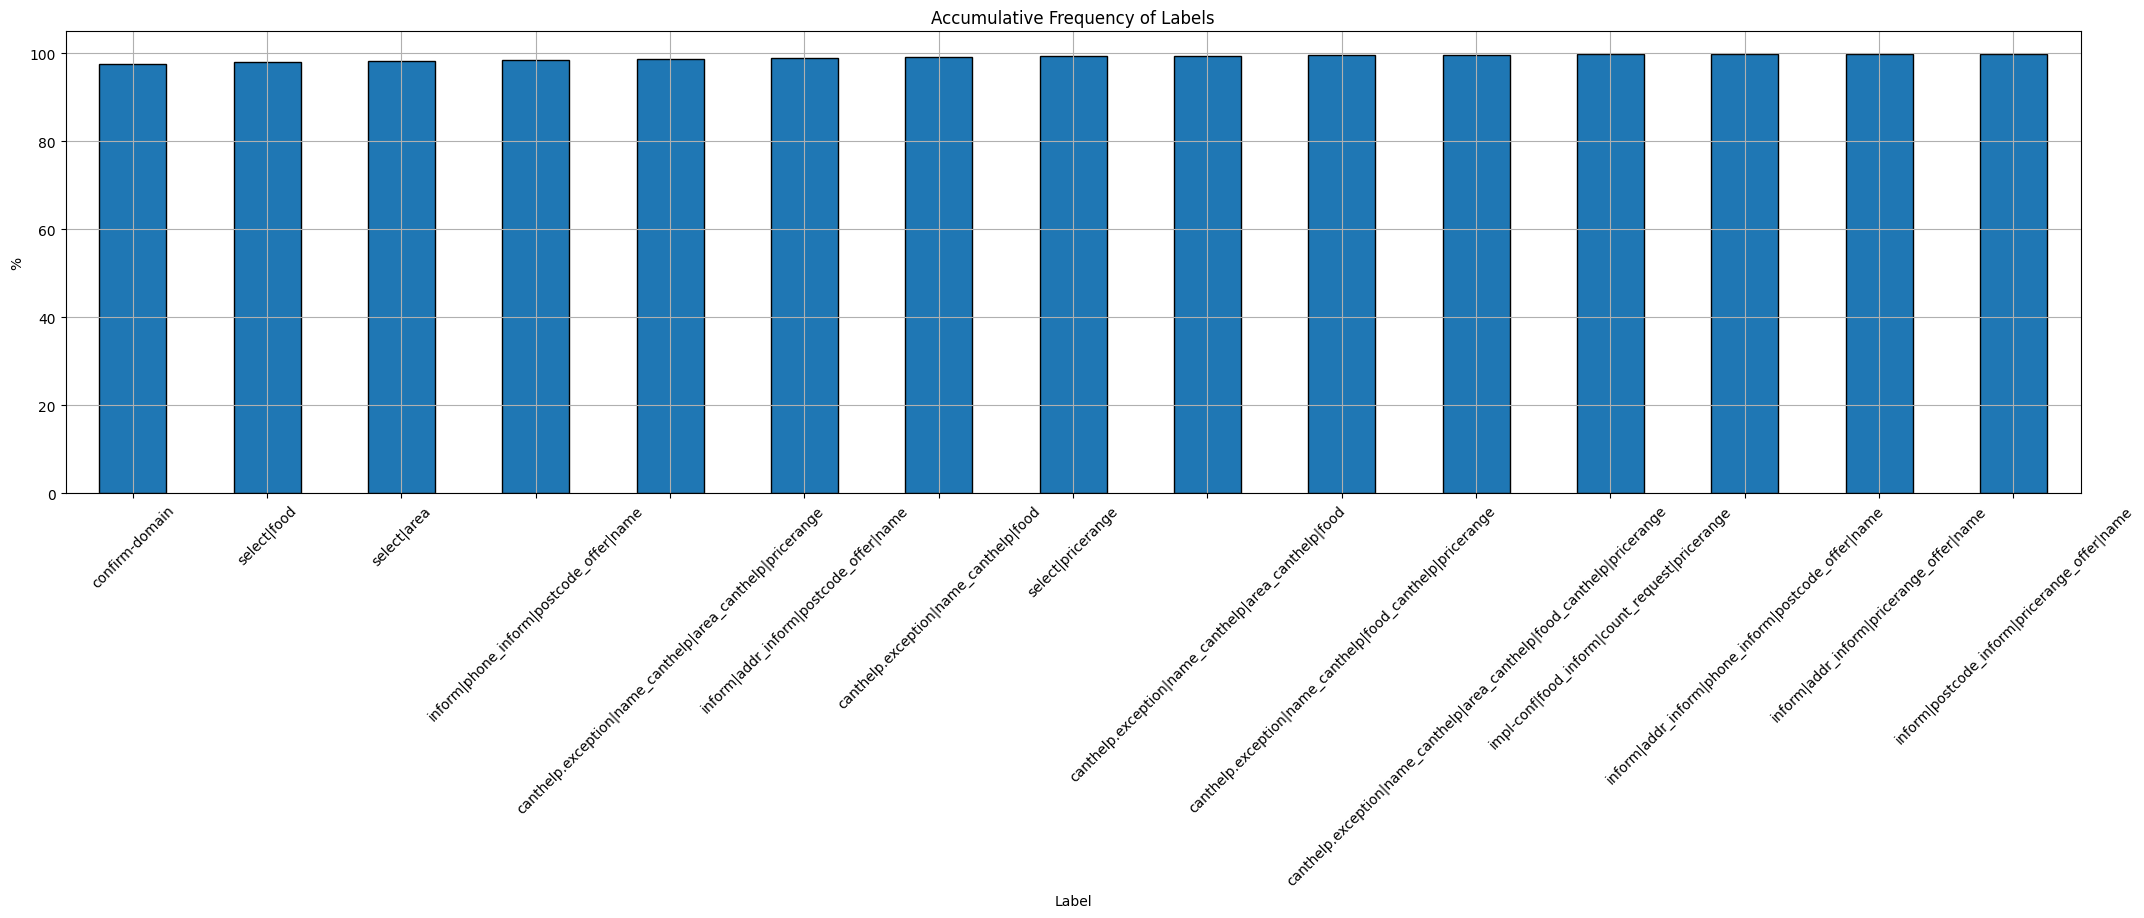

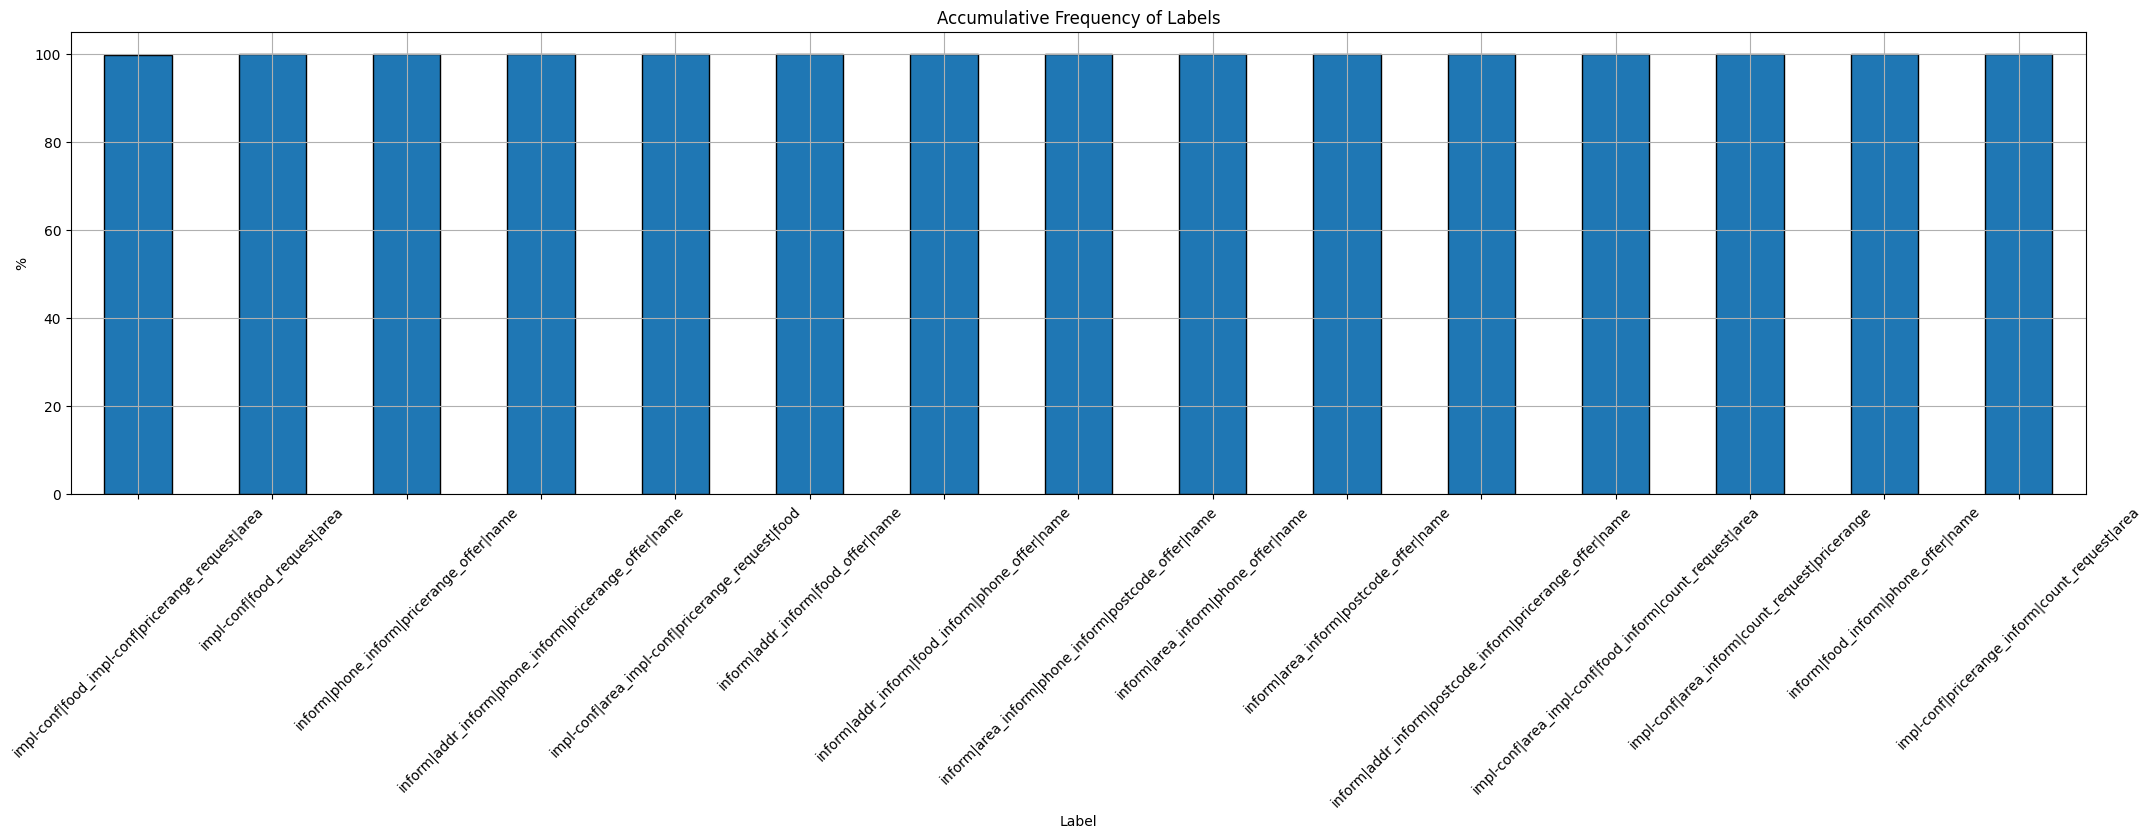

In [29]:
# Get frequency of each label and sort them
label_counts = df['label'].value_counts().sort_values()[::-1]

cumulative_label_counts = label_counts.cumsum() / sum(label_counts) * 100

num_iterations = (len(label_counts) // 16) + 1

for i in range(num_iterations):
  # Create a new figure for each iteration
  plt.figure(figsize=(26, 6))

  # Extract subset of data for this iteration
  subset_label_counts = cumulative_label_counts[15*i:15*(i+1)]

  # Create bar plot for this subset
  subset_label_counts.plot(kind='bar', edgecolor='black')

  plt.title('Accumulative Frequency of Labels')
  plt.xlabel('Label')
  plt.ylim(0, cumulative_label_counts.max() + 5)
  plt.ylabel('%')
  plt.xticks(rotation=45)
  plt.grid()
  plt.show()

**Observations**

- There are a lot of classes (60).

- The dataset is very unbalanced: The most common 16 classes correspond to the 80% of the labels observed in the dataset.

- Uncommon labels tend to correspond to several decision of the dialogue policy on the same turn.

- Rare labels:
  - *Repeat* (The system requesting the user to repeat what he or she said). It is pretty common.
  - I few labels contain *canthelp* and sometimes the same labels also include *canthelp.exception*.

### 2.3) Sampling rate

In [30]:
df_audios['sampling_rate'].unique()

array([16000])

In [31]:
sampling_rate = 16000

### 2.4) Audio length histogram

In [32]:
audio_seconds = df_audios['array'].apply(len) / sampling_rate

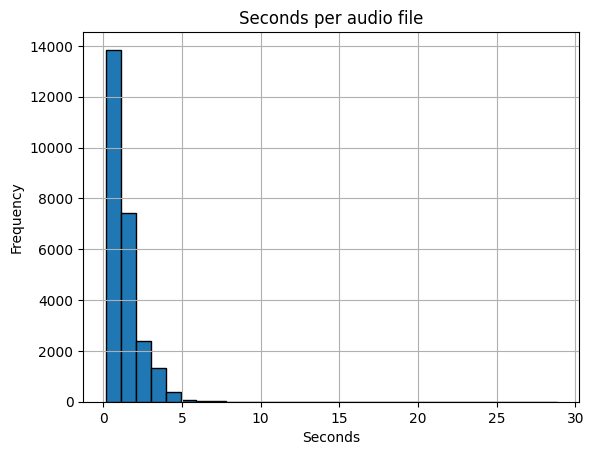

In [33]:
# Plot a histogram of the 'values' column
plt.hist(audio_seconds, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.title('Seconds per audio file')
plt.grid(True)
plt.show()

### 2.3) Audio length boxplot

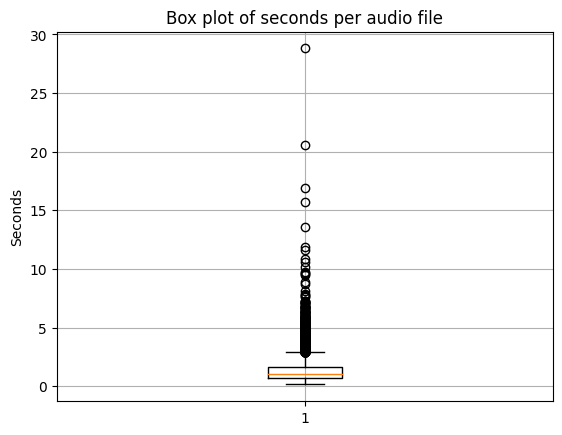

In [34]:
plt.boxplot(audio_seconds)
plt.xlabel('')
plt.ylabel('Seconds')
plt.title('Box plot of seconds per audio file')
plt.grid(True)
plt.show()

### 2.4) Audio length cumulative count

In [35]:
audio_seconds.mean(), audio_seconds.median()

(1.3357667345978994, 1.04)

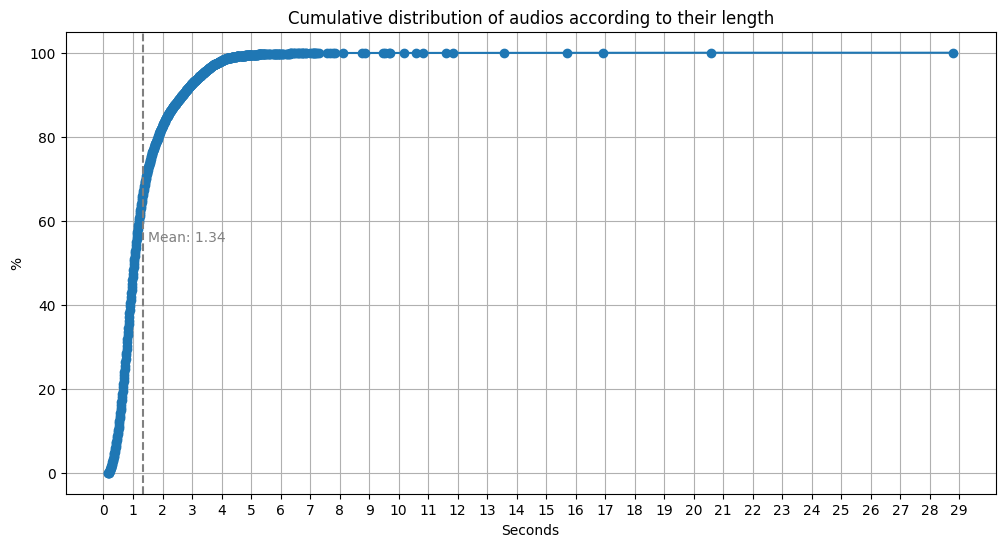

In [98]:
# Count the occurrences of each second length
counts = audio_seconds.value_counts().sort_index() / len(df_audios) * 100

# Calculate the cumulative sum
cumulative_counts = counts.cumsum()

# Calculate the average
average = np.mean(audio_seconds)

# Plot the cumulative count
plt.figure(figsize=(12, 6))
plt.plot(cumulative_counts.index, cumulative_counts.values, marker='o')

# Add vertical line for the mean
plt.axvline(x=average, color='gray', linestyle='--')

# Annotate the mean value next to the vertical line
plt.annotate(f'Mean: {average:.2f}', xy=(average, 50), xytext=(average+1.5, 55),
             fontsize=10, ha='center', color='gray')

plt.xlabel('Seconds')
plt.ylabel('%')
plt.title("Cumulative distribution of audios according to their length")
plt.xticks(np.arange(0, max(audio_seconds)+1, 1.0))
plt.grid()
plt.show()

In [37]:
seconds = [0.5, 0.75, 1, 2, 3, 4, 4.5, 5]

for s in seconds:
  n_lower_s = (audio_seconds <= s).sum()
  print(f"Audios with length lower than {s} seconds: {n_lower_s / len(df_audios) * 100}%")

Audios with length lower than 0.5 seconds: 10.170089355698385%
Audios with length lower than 0.75 seconds: 27.12415739144066%
Audios with length lower than 1 seconds: 47.34284370591001%
Audios with length lower than 2 seconds: 82.610910801066%
Audios with length lower than 3 seconds: 92.65558865025866%
Audios with length lower than 4 seconds: 98.08355541620944%
Audios with length lower than 4.5 seconds: 99.09860479699012%
Audios with length lower than 5 seconds: 99.50227308355541%


### 2.5) Text lenght distribution

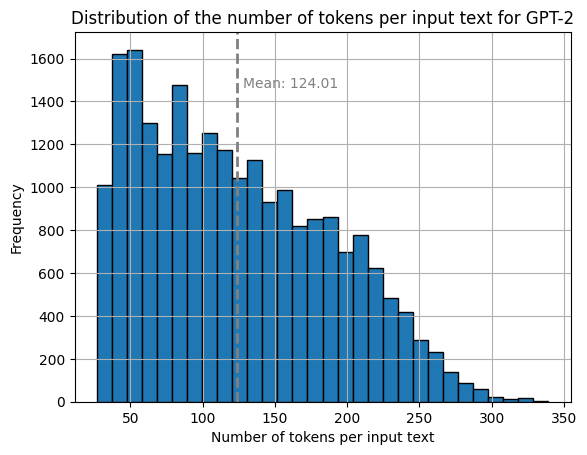

In [89]:
transcript_lenght = df['attention_mask'].apply(sum)


# Calculate the mean
mean_value = transcript_lenght.mean()

# Plot the histogram
plt.hist(transcript_lenght, bins=30, edgecolor='black')
plt.xlabel('Number of tokens per input text')
plt.ylabel('Frequency')
plt.title('Distribution of the number of tokens per input text for GPT-2')
plt.grid(True)

# Add a dashed line for the mean
plt.axvline(mean_value, color='grey', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')

# Add text annotation for mean value
plt.text(mean_value+70, plt.ylim()[1]*0.85, f'Mean: {mean_value:.2f}', color='grey', ha='right')

# Show plot
plt.show()

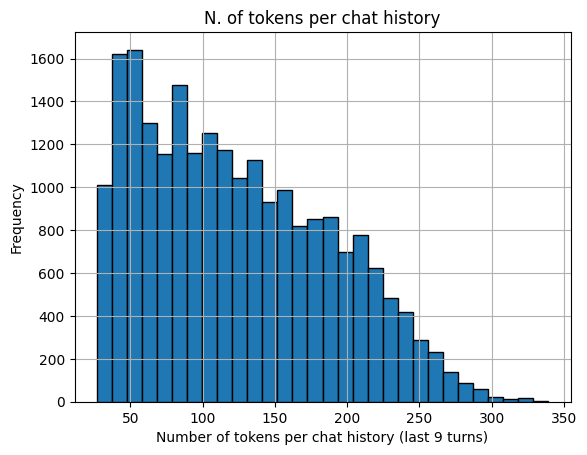

In [39]:
chat_history_tokens = df['attention_mask'].apply(lambda x: sum(x))

# Plot a histogram of the 'values' column
plt.hist(chat_history_tokens, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Number of tokens per chat history (last 9 turns)')
plt.ylabel('Frequency')
plt.title('N. of tokens per chat history')
plt.grid(True)
plt.show()

In [40]:
# After padding to the maximum length
df['attention_mask'].str.len().unique()

array([339])

### 2.6) Number of messages per session

In [41]:
df.groupby('session_id').size().mean(), df.groupby('session_id').size().median()

(6.882843894899536, 6.0)

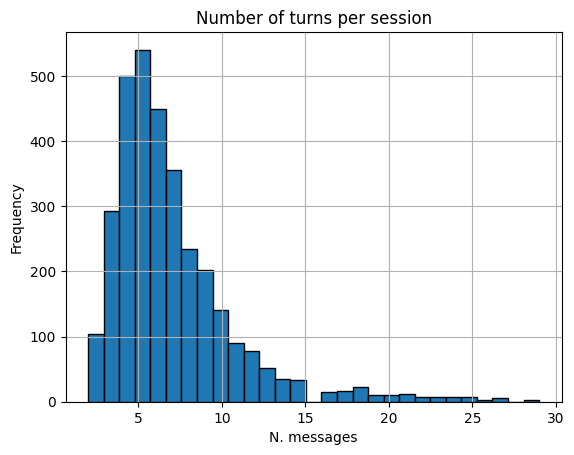

In [42]:
# Plot a histogram of the 'values' column
plt.hist(df.groupby('session_id').size(), bins=29, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('N. messages')
plt.ylabel('Frequency')
plt.title('Number of turns per session')
plt.grid(True)
plt.show()

## 3) Study dataset partitions

### 3.1) Ensure that the audio for each row exists

In [43]:
(~df['audio_file'].isin(df_audios['path'])).sum()

0

### 3.2) Merge dataset

In [44]:
# # We filter to keep only the audios of length lower or equal to 4.5 seconds
# cond = df_audios['array'].apply(len) <= 4.5 * 16000
# df_audios = df_audios[cond]

In [45]:
df_audios = df_audios.drop(['sampling_rate'], axis=1)
df_audios.head()

,session_ids,path,array
0,voip-00d76b791d-20130327_010416,pt344x_0000993_0001219.wav,"[0.000335693359375, 0.000335693359375, 0.00012..."
1,voip-00d76b791d-20130327_010416,pt344x_0001649_0001680.wav,"[0.0001220703125, 0.000152587890625, 0.0003356..."
2,voip-00d76b791d-20130327_010416,pt344x_0002674_0002736.wav,"[0.000152587890625, 0.000152587890625, 0.00027..."
3,voip-00d76b791d-20130327_010416,pt344x_0003533_0003611.wav,"[0.000213623046875, 0.00054931640625, 0.000671..."
4,voip-00d76b791d-20130327_010416,pt344x_0004453_0004531.wav,"[0.000213623046875, 0.000335693359375, 0.00027..."


In [46]:
df_audios = df_audios.rename({'path': 'audio_file',
                              'session_ids': 'session_id'}, axis=1)

In [47]:
print(len(df))
len(df.merge(df_audios, on=['audio_file', 'session_id']))

22266


22266

In [48]:
df = df.merge(df_audios, on=['audio_file', 'session_id'])
df.head()

,session_id,turn_index,audio_file,transcript,chat_history_last_9,chat_history_last_9_tokenized,speaker_text_last_9_tokenized,attention_mask,label_semantics,label,array
0,voip-00d76b791d-20130327_010416,2,pt344x_0000993_0001219.wav,<user>expensive restaurant in the south part o...,"<sys>Hello , welcome to the Cambridge restaura...","[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|area_inform|pricerange,request|food,"[0.000335693359375, 0.000335693359375, 0.00012..."
1,voip-00d76b791d-20130327_010416,4,pt344x_0001649_0001680.wav,<user>any<API_call><DB_result>,"<sys>Hello , welcome to the Cambridge restaura...","[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|this,inform|area_inform|food_inform|pricerange_offe...,"[0.0001220703125, 0.000152587890625, 0.0003356..."
2,voip-00d76b791d-20130327_010416,6,pt344x_0002674_0002736.wav,<user>address<API_call><DB_result>,"<sys>Hello , welcome to the Cambridge restaura...","[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",request|addr,inform|addr_offer|name,"[0.000152587890625, 0.000152587890625, 0.00027..."
3,voip-00d76b791d-20130327_010416,8,pt344x_0003533_0003611.wav,<user>type of food<API_call><DB_result>,"<sys>Hello , welcome to the Cambridge restaura...","[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",request|food,inform|area_inform|pricerange_offer|name,"[0.000213623046875, 0.00054931640625, 0.000671..."
4,voip-00d76b791d-20130327_011116,2,pt344x_0001082_0001294.wav,<user>lebanese restaurant in the west part of ...,"<sys>Hello , welcome to the Cambridge restaura...","[50258, 15496, 837, 7062, 284, 262, 14457, 707...","[50258, 50258, 50258, 50258, 50258, 50258, 502...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",inform|area_inform|food,request|food,"[0.0, -6.103515625e-05, -6.103515625e-05, 0.0,..."


### 3.3) Ensure that each row is in a partition

In [49]:
df_train = df[df['session_id'].isin(train_session_ids)]
df_dev = df[df['session_id'].isin(dev_session_ids)]
df_test = df[df['session_id'].isin(test_session_ids)]

In [50]:
assert len(df) == len(df_train) + len(df_dev) + len(df_test)

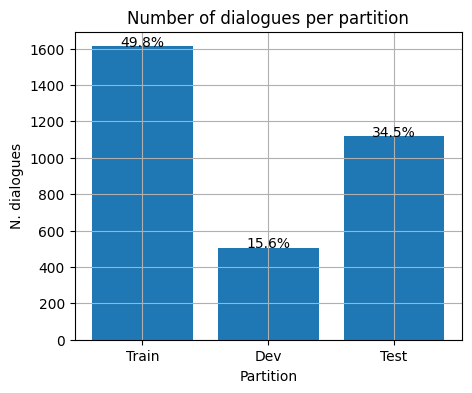

In [51]:
# barplot sessions
sizes = [df_train['session_id'].nunique(), df_dev['session_id'].nunique(),
         df_test['session_id'].nunique()]
labels = ['Train', 'Dev', 'Test']

plt.figure(figsize=(5,4))

plt.bar(labels, sizes)
plt.xlabel('Partition')
plt.ylabel('N. dialogues')
plt.title('Number of dialogues per partition')
plt.grid()

# Add percentage annotations above each bar
for i in range(len(sizes)):
    plt.text(i, sizes[i] + 0.1, f'{sizes[i]/sum(sizes)*100:.1f}%', ha='center')

# Show plot
plt.show()

In [54]:
sizes = [df_train['session_id'].nunique(), df_dev['session_id'].nunique(),
         df_test['session_id'].nunique()]
sizes

[1612, 506, 1117]

In [57]:
sizes = [len(df_train), len(df_dev), len(df_test)]
sizes

[10065, 3428, 8773]

In [59]:
sum(sizes)

22266

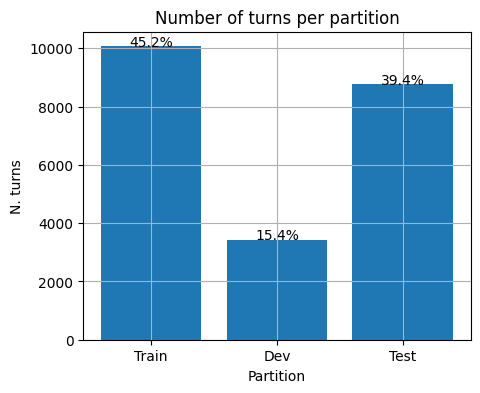

In [60]:
# barplot n. rows
sizes = [len(df_train), len(df_dev), len(df_test)]
labels = ['Train', 'Dev', 'Test']

plt.figure(figsize=(5,4))

plt.bar(labels, sizes)
plt.xlabel('Partition')
plt.ylabel('N. turns')
plt.title('Number of turns per partition')
plt.grid()

# Add percentage annotations above each bar
for i in range(len(sizes)):
    plt.text(i, sizes[i] + 0.1, f'{sizes[i]/sum(sizes)*100:.1f}%', ha='center')

# Show plot
plt.show()

### 3.4) Label distribution

#### 3.4.1) Train

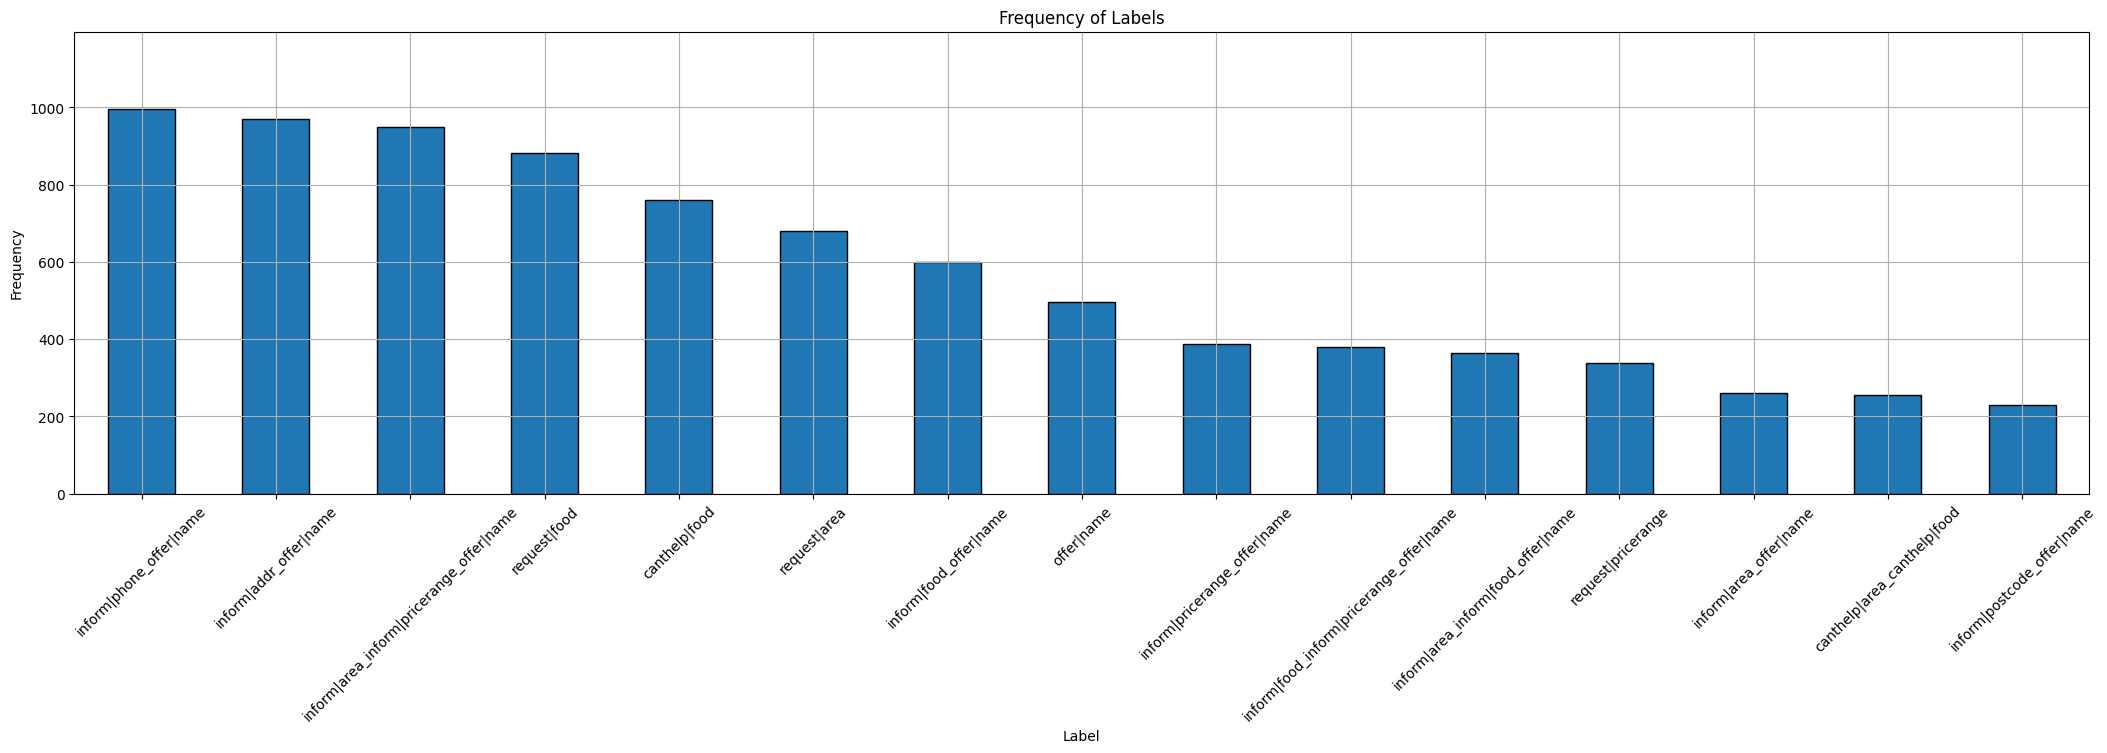

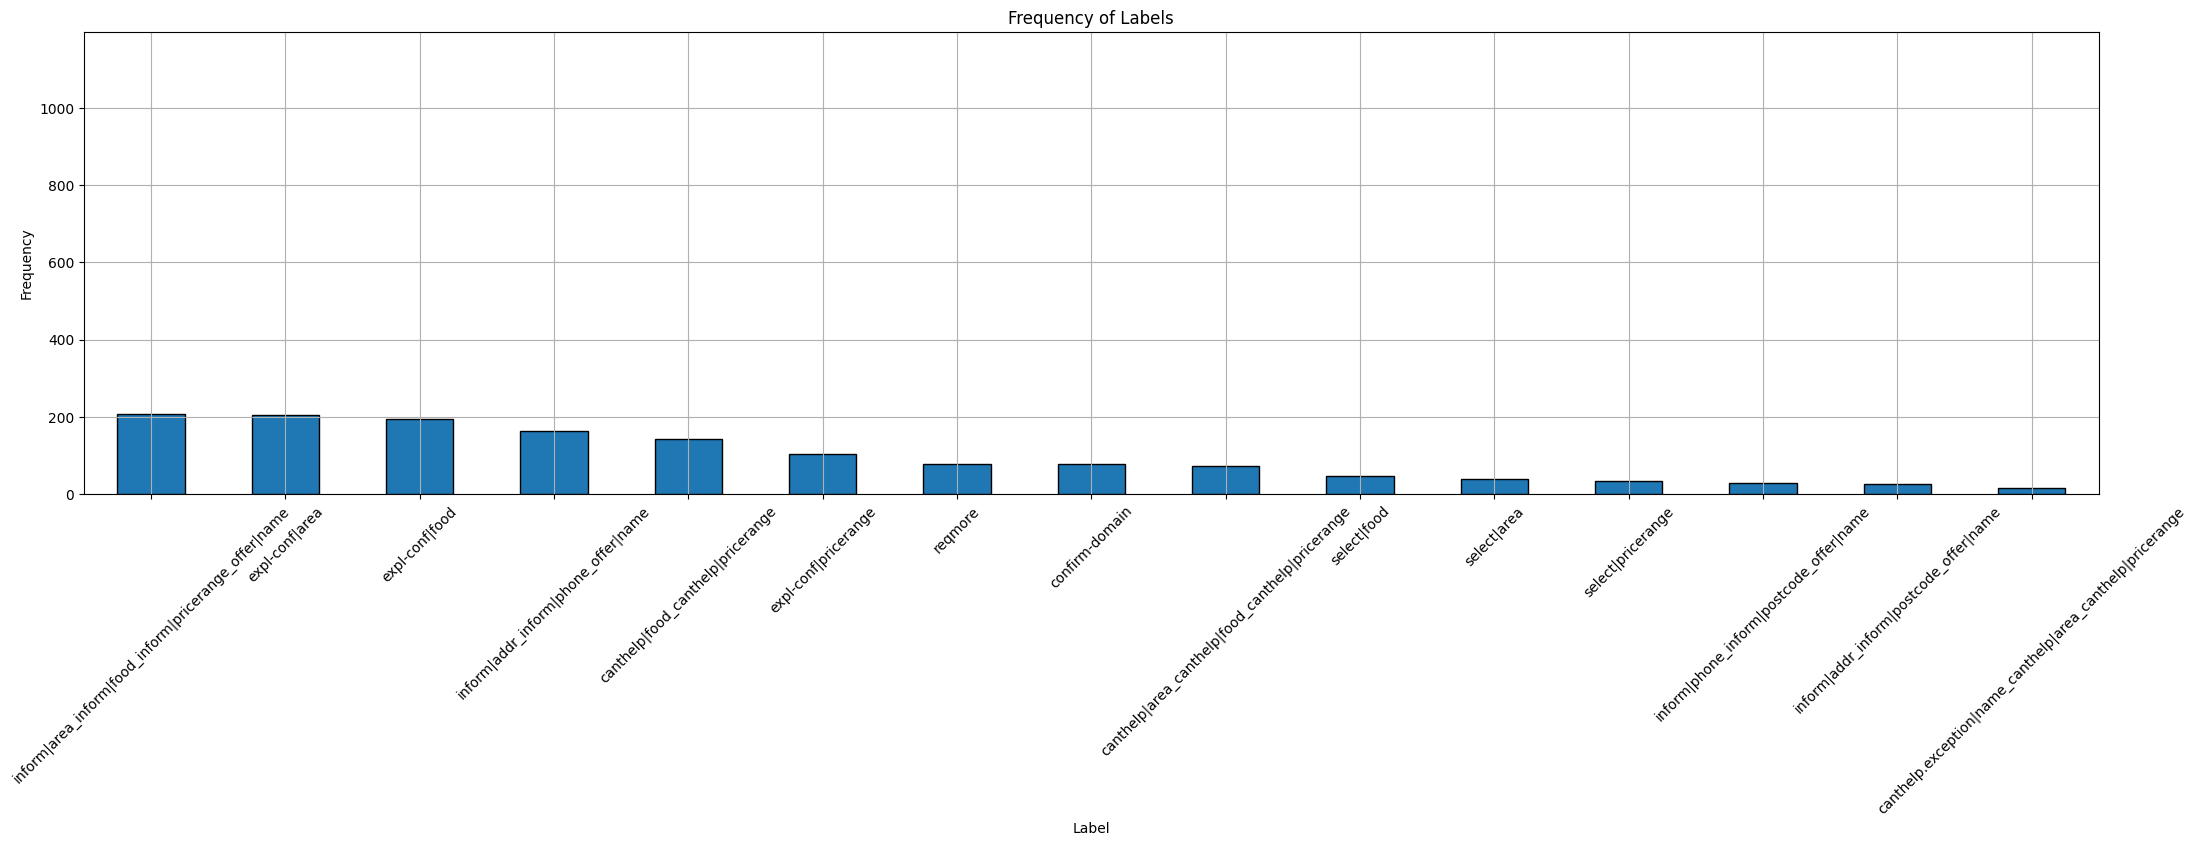

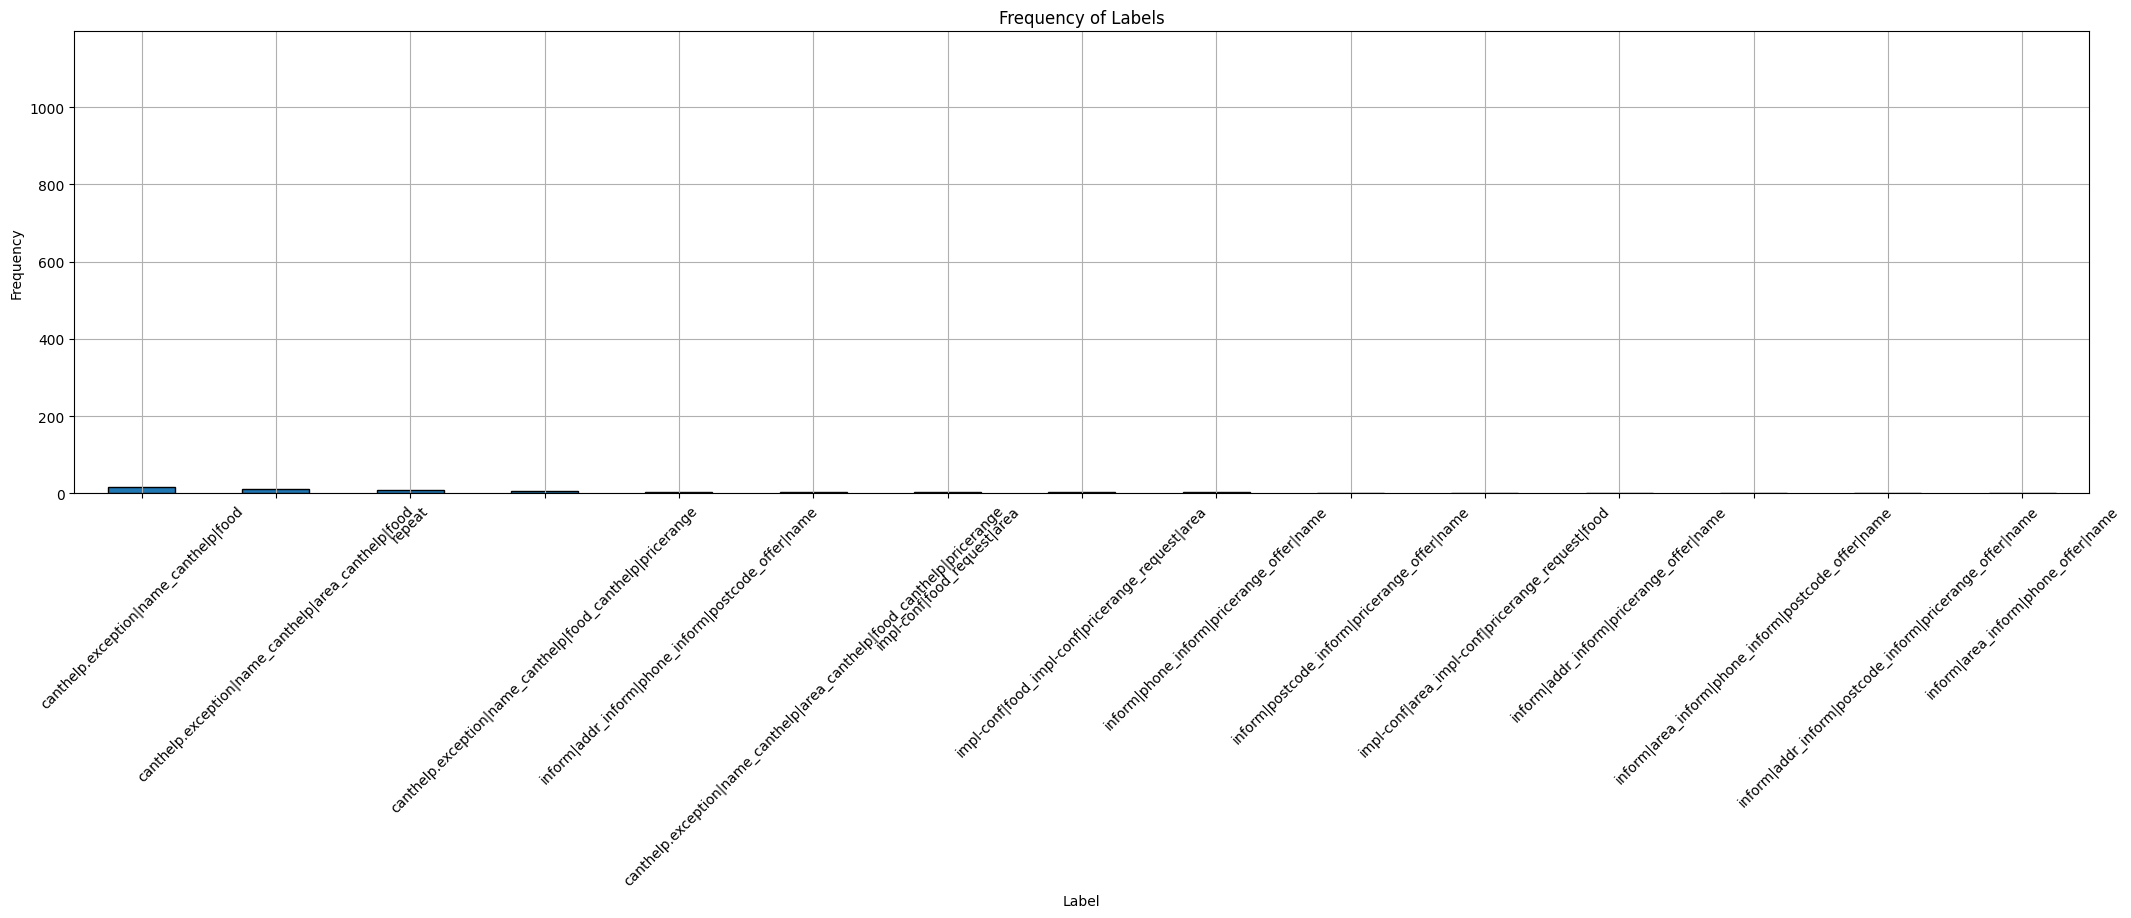

In [ ]:
# Get frequency of each label and sort them
label_counts = df_train['label'].value_counts().sort_values()[::-1]

num_iterations = (len(label_counts) // 16) + 1

for i in range(num_iterations):
  # Create a new figure for each iteration
  plt.figure(figsize=(26, 6))

  # Extract subset of data for this iteration
  subset_label_counts = label_counts[15*i:15*(i+1)]

  # Create bar plot for this subset
  subset_label_counts.plot(kind='bar', edgecolor='black')

  plt.title('Frequency of Labels')
  plt.xlabel('Label')
  plt.ylim(0, label_counts.max() + 200)
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)
  plt.grid()
  plt.show()

#### 3.4.2) Dev

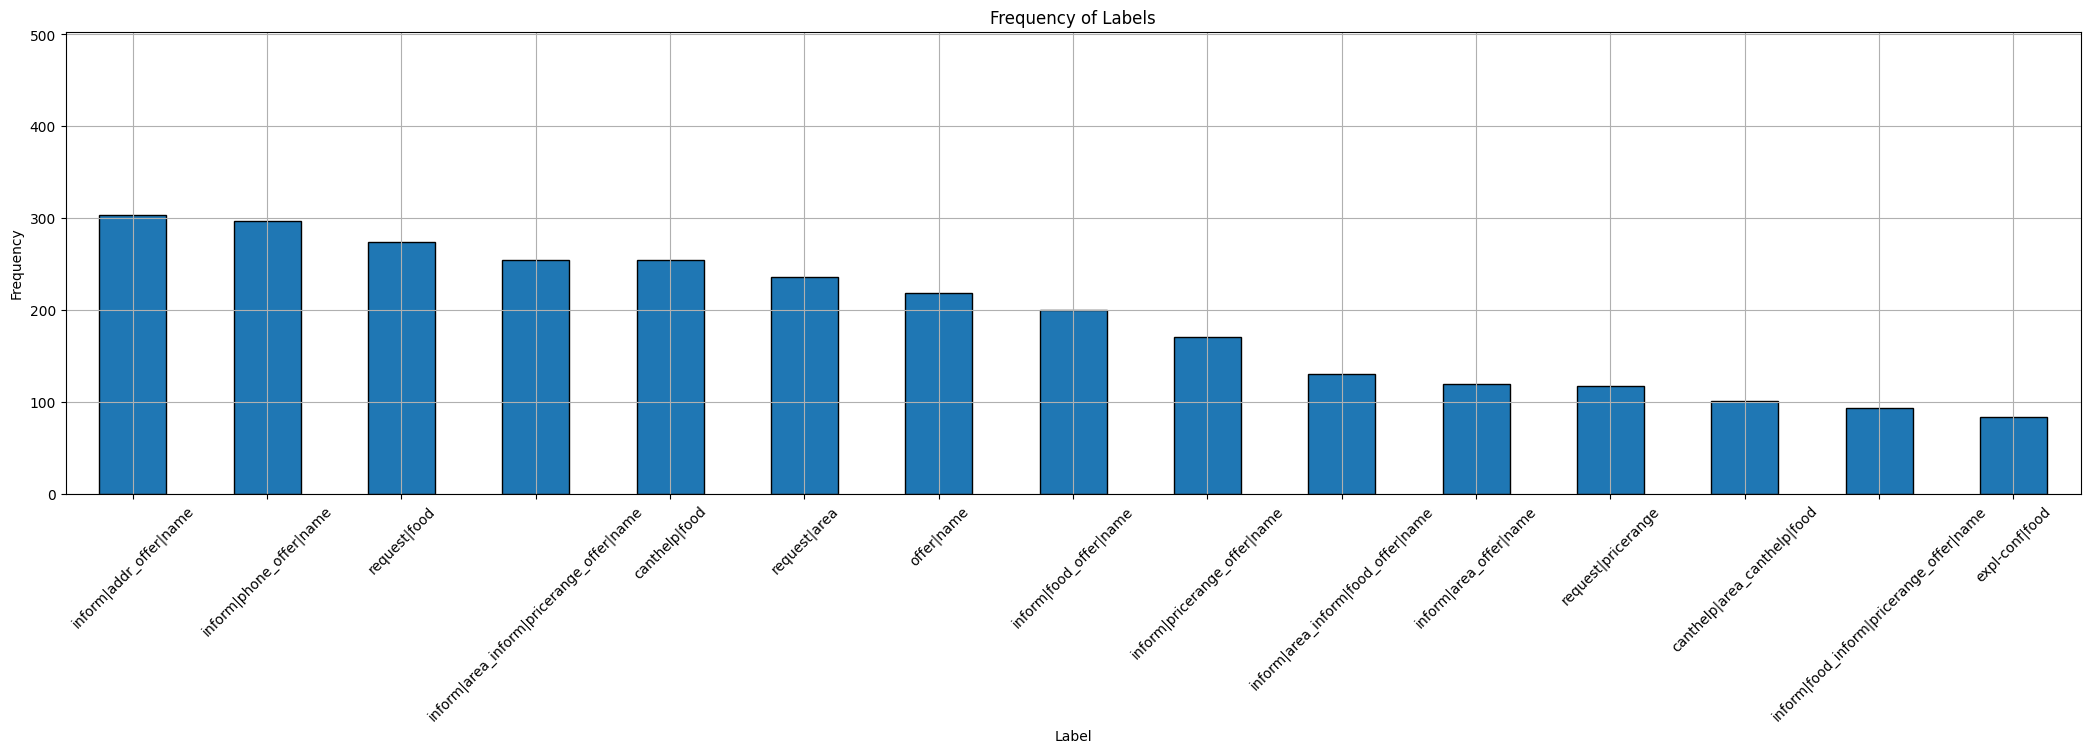

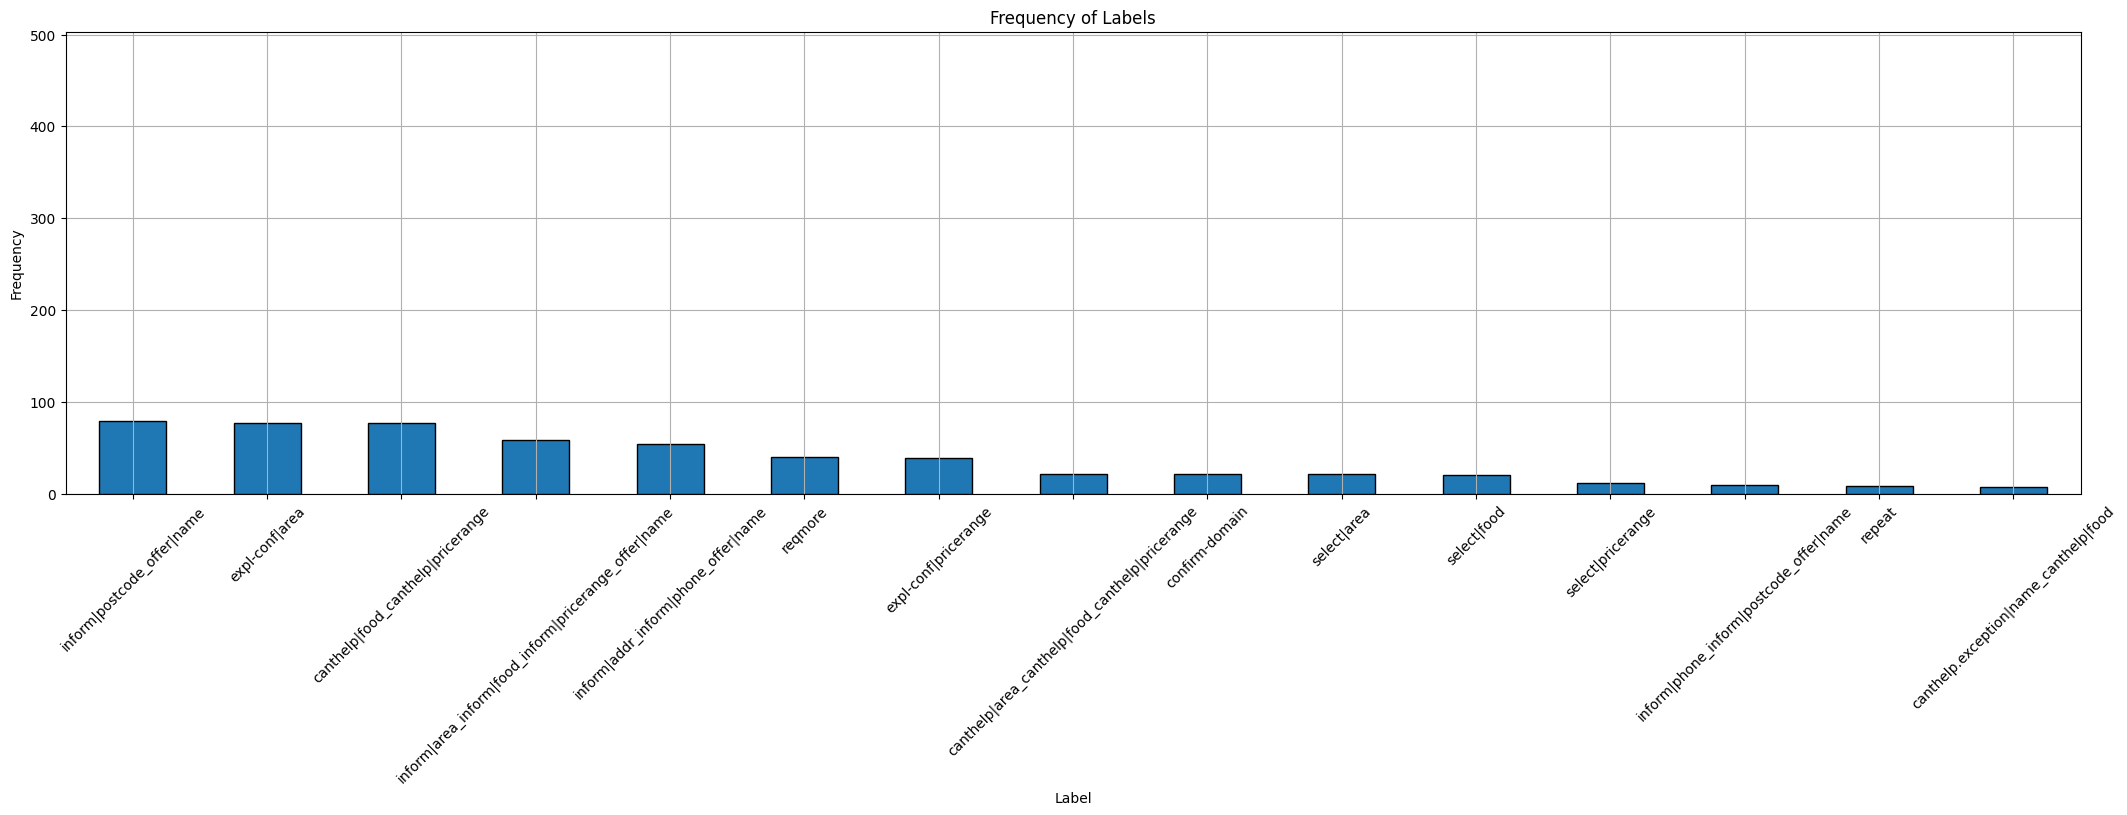

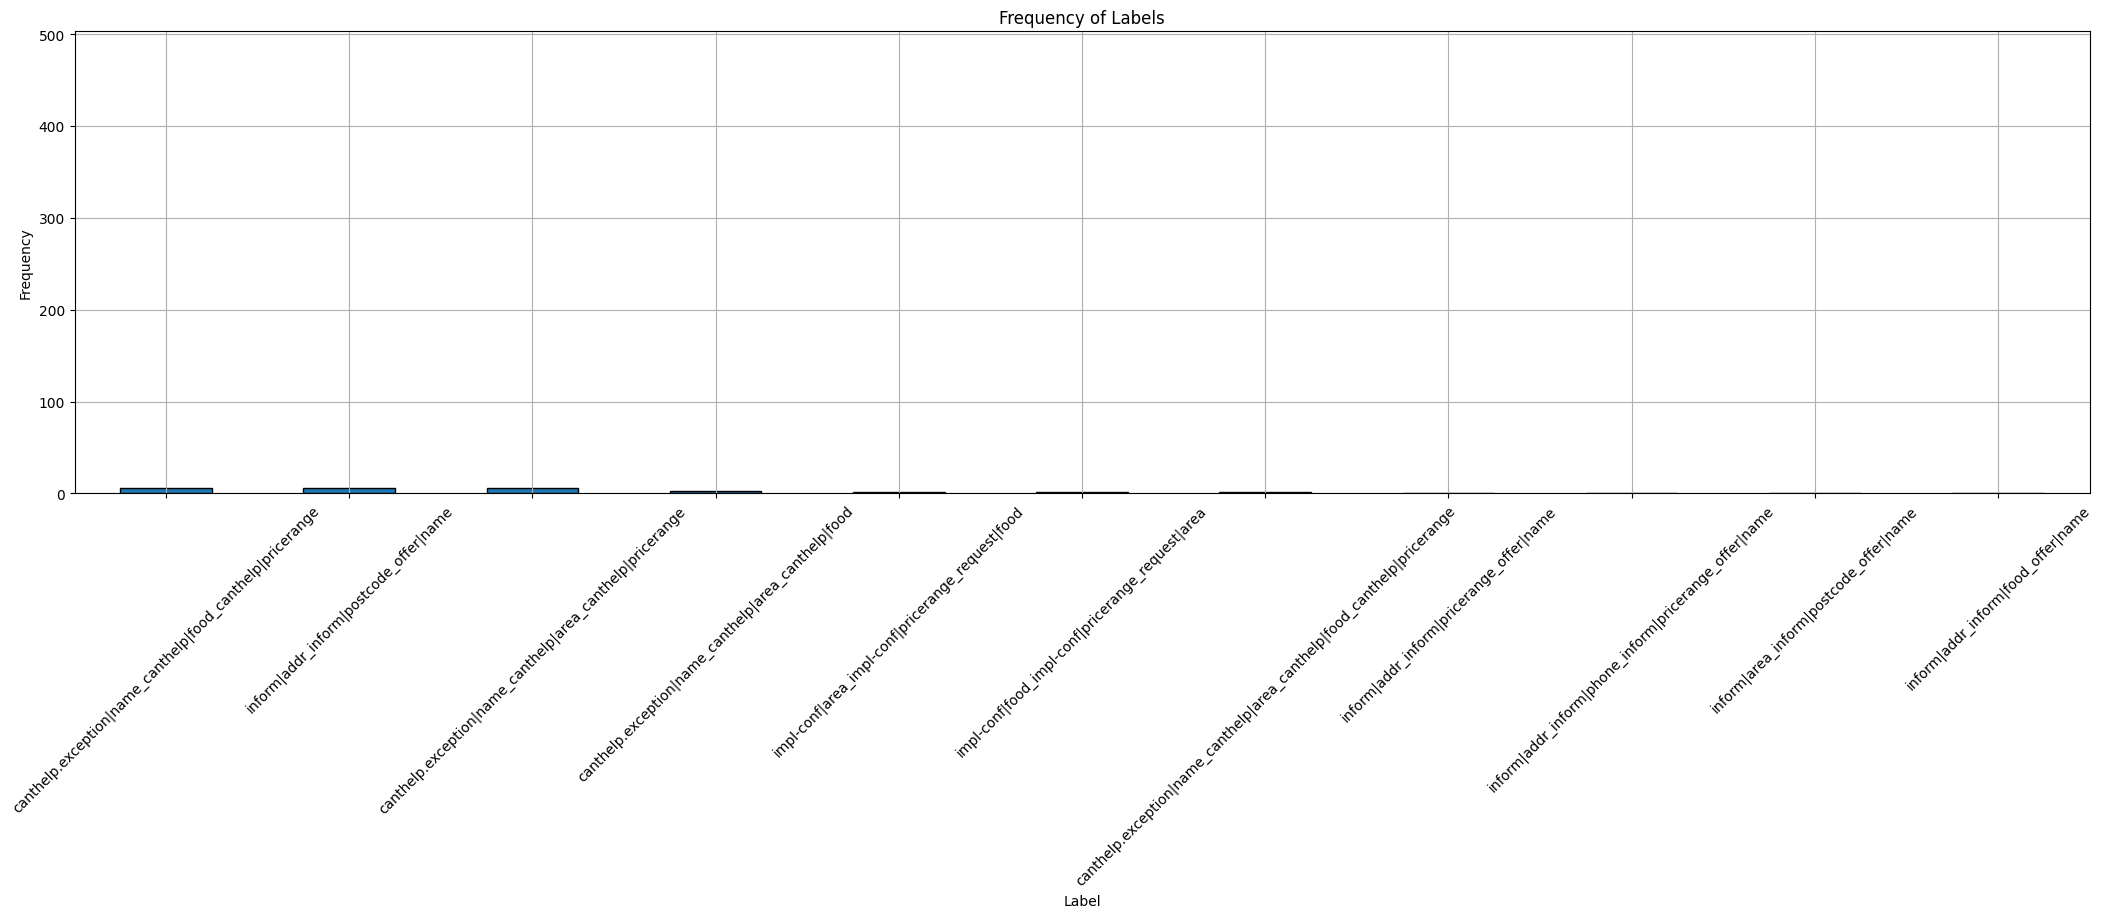

In [ ]:
# Get frequency of each label and sort them
label_counts = df_dev['label'].value_counts().sort_values()[::-1]

num_iterations = (len(label_counts) // 16) + 1

for i in range(num_iterations):
  # Create a new figure for each iteration
  plt.figure(figsize=(26, 6))

  # Extract subset of data for this iteration
  subset_label_counts = label_counts[15*i:15*(i+1)]

  # Create bar plot for this subset
  subset_label_counts.plot(kind='bar', edgecolor='black')

  plt.title('Frequency of Labels')
  plt.xlabel('Label')
  plt.ylim(0, label_counts.max() + 200)
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)
  plt.grid()
  plt.show()

#### 3.4.3) Test

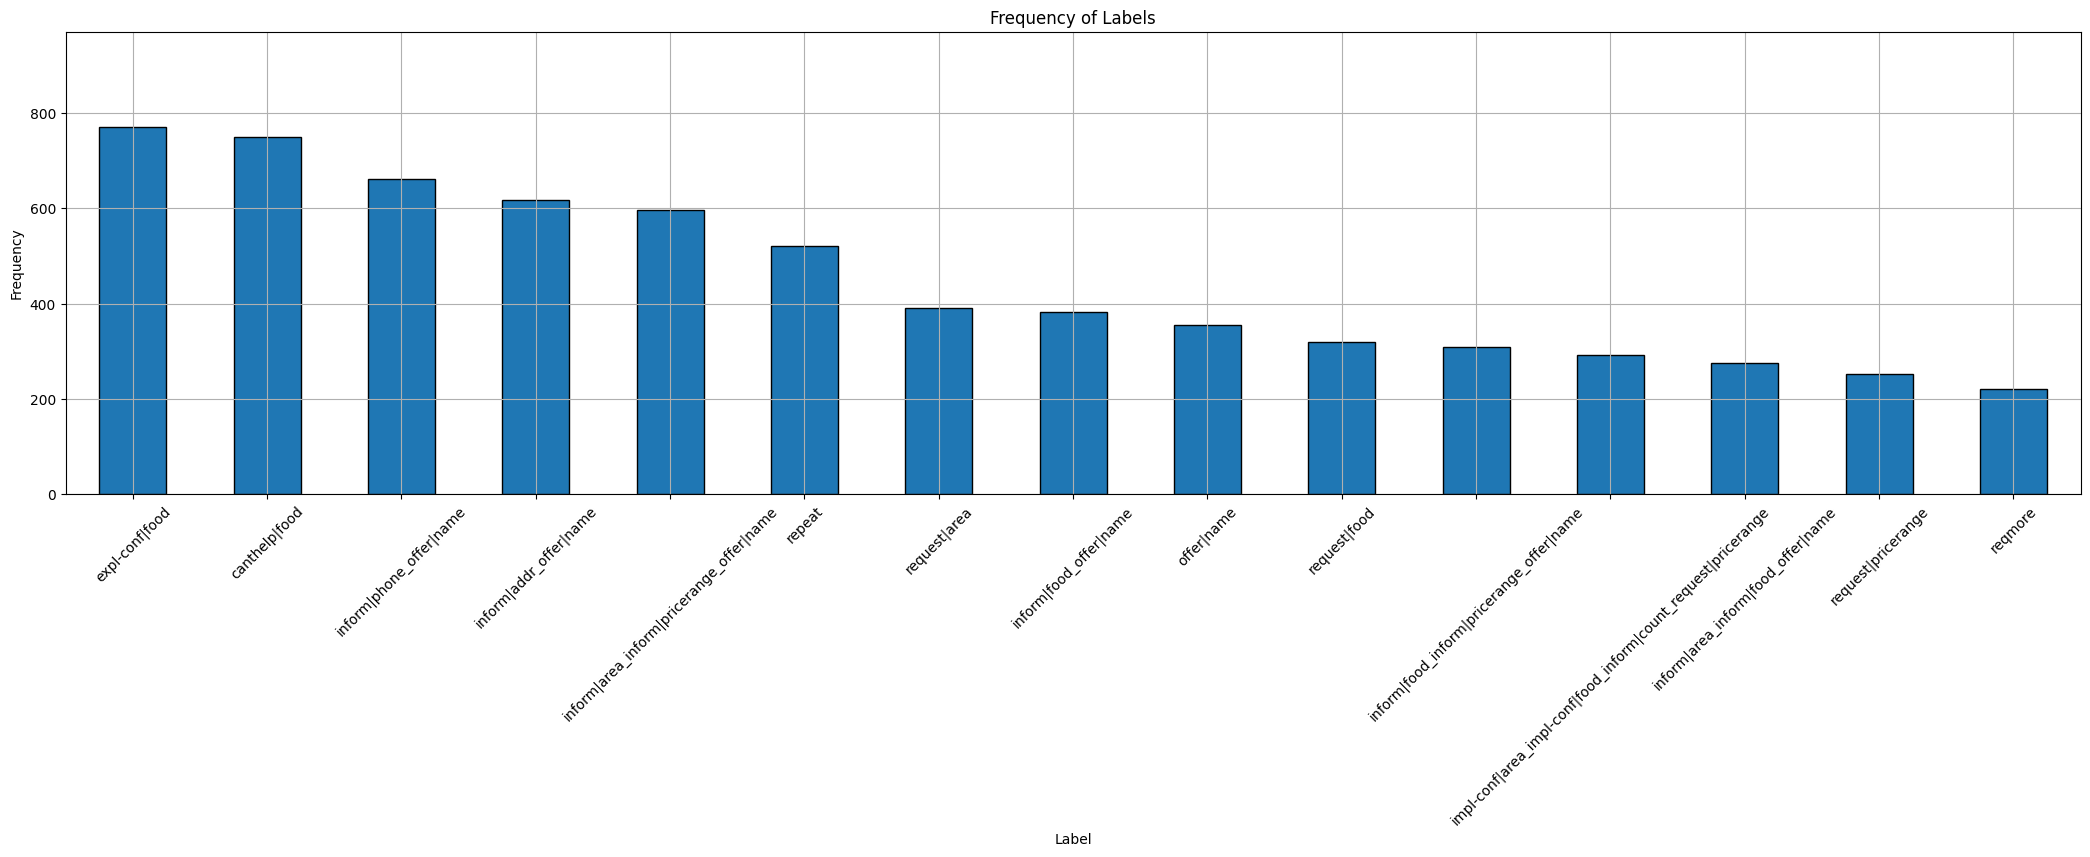

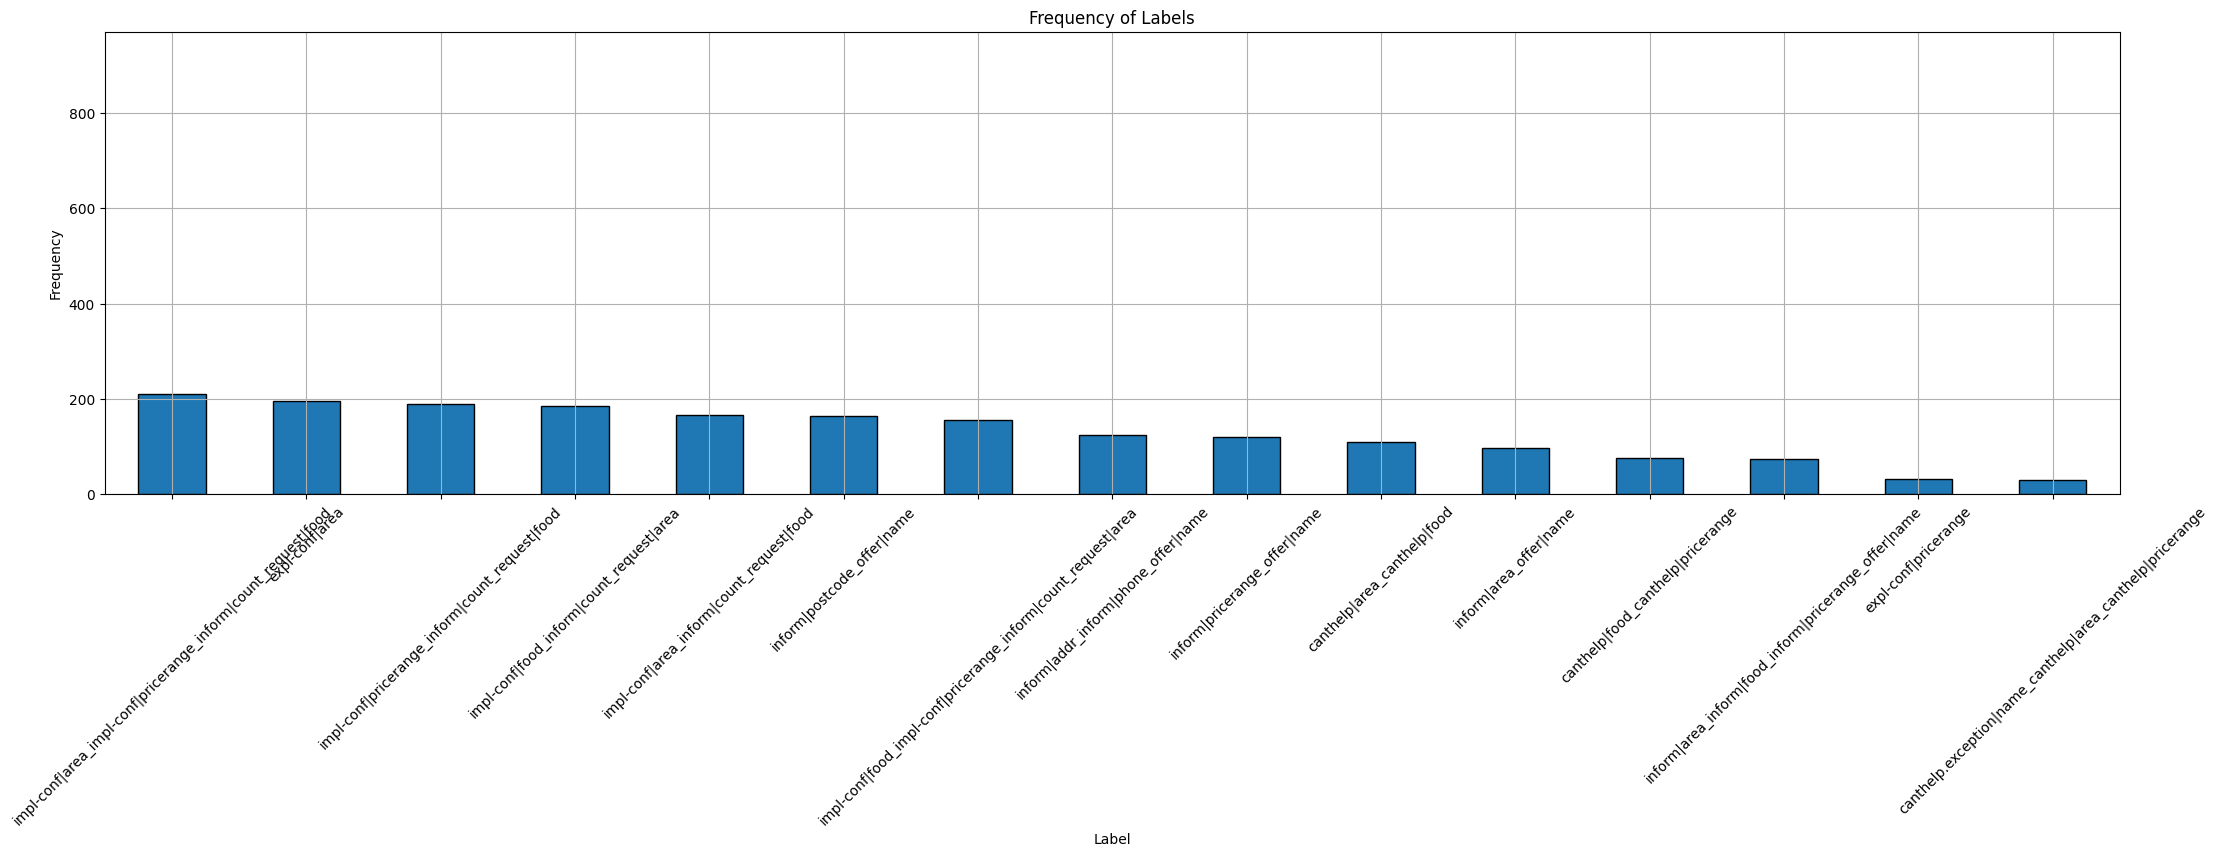

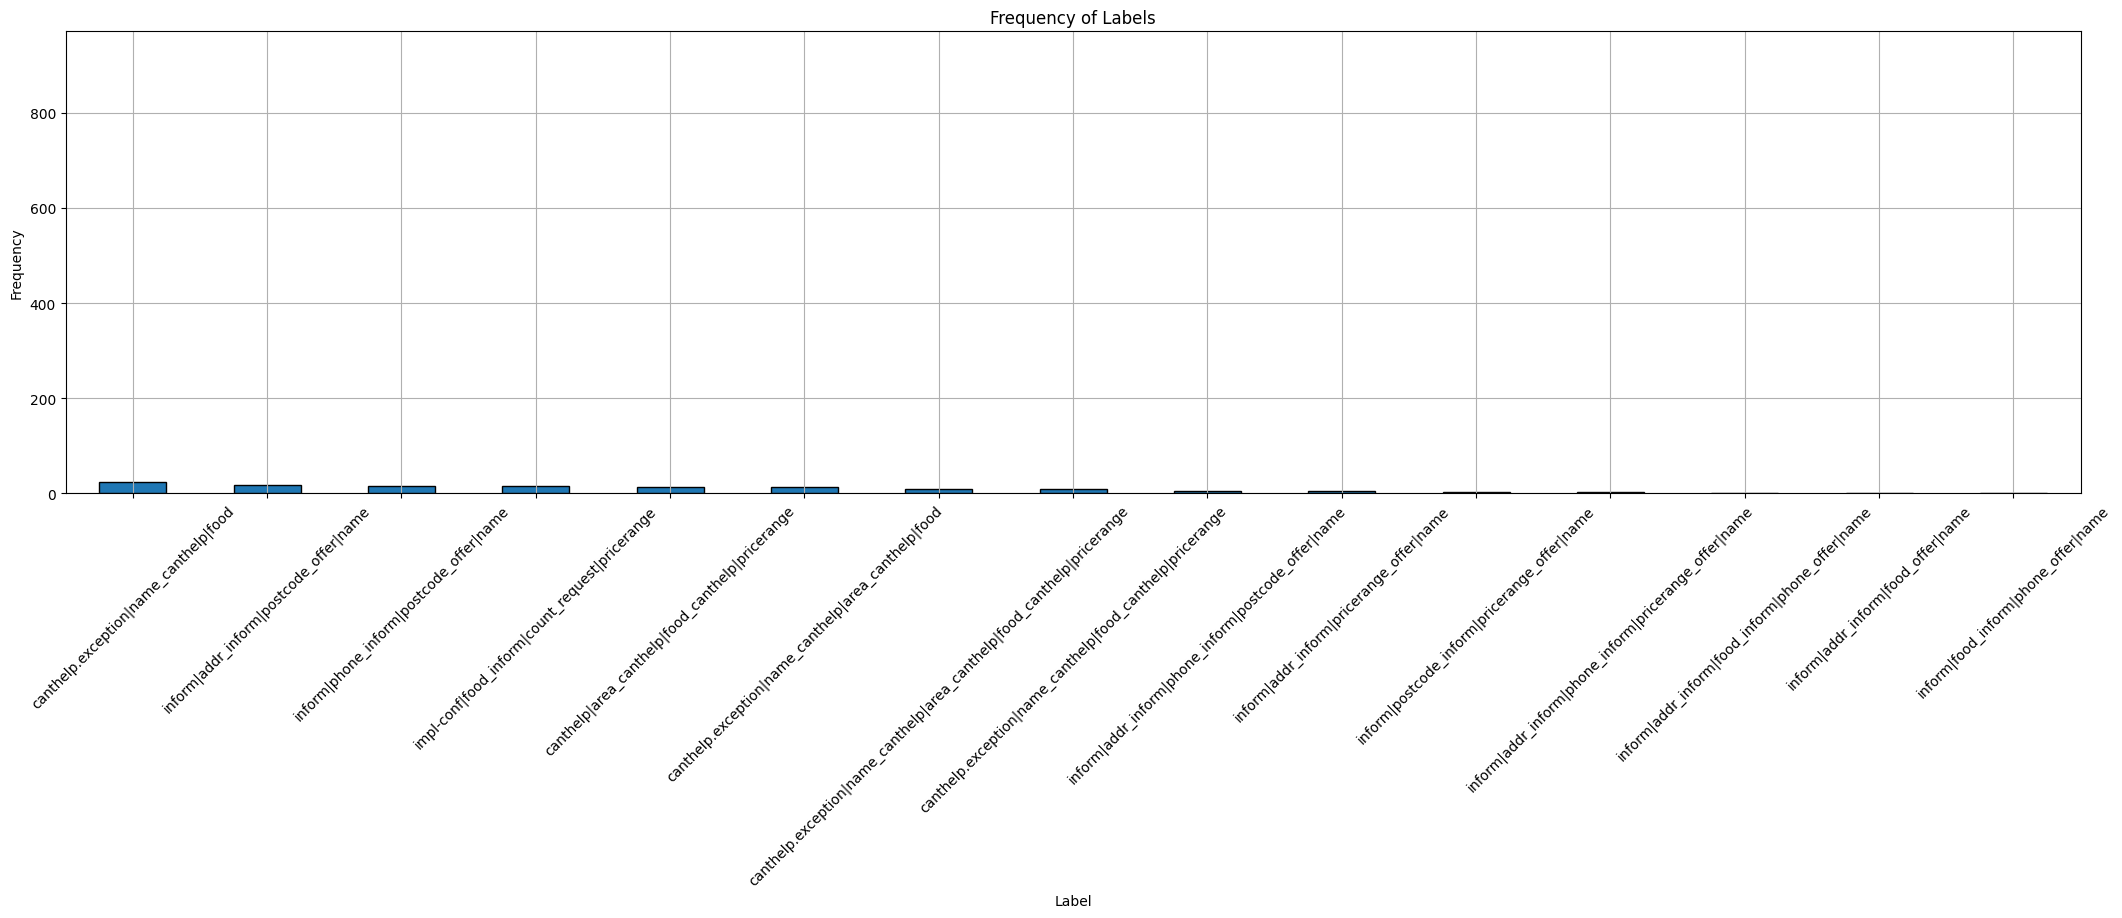

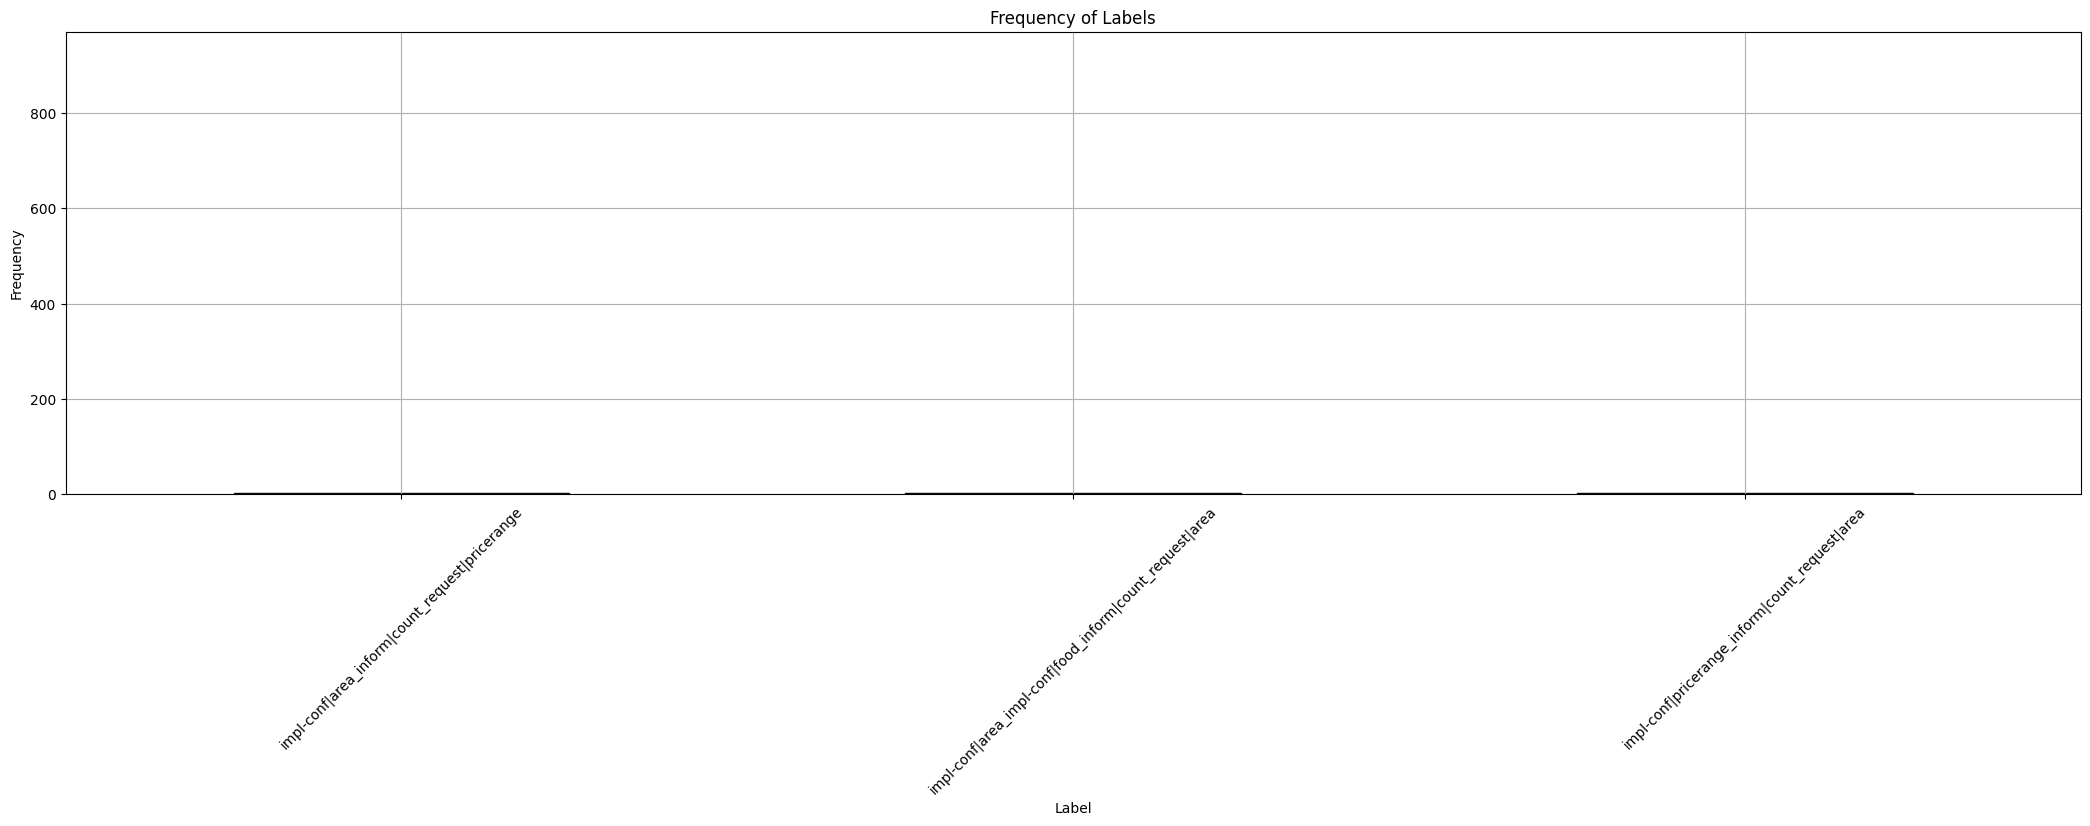

In [ ]:
# Get frequency of each label and sort them
label_counts = df_test['label'].value_counts().sort_values()[::-1]

num_iterations = (len(label_counts) // 16) + 1

for i in range(num_iterations):
  # Create a new figure for each iteration
  plt.figure(figsize=(26, 6))

  # Extract subset of data for this iteration
  subset_label_counts = label_counts[15*i:15*(i+1)]

  # Create bar plot for this subset
  subset_label_counts.plot(kind='bar', edgecolor='black')

  plt.title('Frequency of Labels')
  plt.xlabel('Label')
  plt.ylim(0, label_counts.max() + 200)
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)
  plt.grid()
  plt.show()

### 3.5) Number of labels

In [ ]:
df['label'].nunique()

60

In [ ]:
df_train['label'].nunique(),  df_dev['label'].nunique(), df_test['label'].nunique()

(45, 41, 48)

### 3.5) Check whether there are unique samples per partition

In [ ]:
train_labels = set(df_train['label'].unique())
dev_labels = set(df_dev['label'].unique())
test_labels = set(df_test['label'].unique())

In [ ]:
print(f"Labels in train but not in dev: {len(train_labels - dev_labels)}")
print(f"Labels in train but not in test: {len(train_labels - test_labels)}")
print('-'*50)
print(f"Labels in dev but not in train: {len(dev_labels - train_labels)}")
print(f"Labels in dev but not in test: {len(dev_labels - test_labels)}")
print('-'*50)
print(f"Labels in test but not in train: {len(test_labels - train_labels)}")
print(f"Labels in test but not in dev: {len(test_labels - dev_labels)}")

Labels in train but not in dev: 7
Labels in train but not in test: 11
--------------------------------------------------
Labels in dev but not in train: 3
Labels in dev but not in test: 7
--------------------------------------------------
Labels in test but not in train: 14
Labels in test but not in dev: 14


**Notes**

* The label distribution in the test dataset is clearly different than in train and dev.

* For train and dev, the label distributions are similar.